In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook
# import ipympl

from scipy.linalg import expm, eig
from scipy.constants import physical_constants, pi, epsilon_0, hbar
from scipy.sparse import csr_matrix
from scipy.special import factorial
from scipy.optimize import curve_fit

from arc import *
from arc.alkali_atom_functions import (_atomLightAtomCoupling)
from arc.wigner import Wigner6j, Wigner3j, CG

In [11]:
import arc

In [12]:
arc.__version__

'3.3.0'

In [13]:
atom = Caesium()
# transition 5 S_{1/2} m_j=-0.5 -> 5 P_{3/2} m_j=-1.5
# for laser driving sigma- transition
print(atom.getDipoleMatrixElement(6,0,0.5,-0.5,6,1,1.5,-0.5,1))

-0.0


## E Field Coupling

Matrix element $\langle n_2 l_2 j_2 m_{j,2} | E\hat{z} | n_1 l_1 j_1 m_{j,1}\rangle$ Calculated using Eq. 10 of Phys. Rev. A 20, 2251 (1979)

In [14]:
Cs_E = Caesium()

def V_e_coupling(state1, state2, E):
    n1,l1,j1,mj1 = state1
    n2,l2,j2,mj2 = state2
    
    s = 1/2
    
    sumPart = 0.0
    for ml in np.linspace(mj1 - s, mj1 + s, round(2 * s + 1)):
        if (abs(ml) - 0.1 < l1) and (abs(ml) - 0.1 < l2):
            angularPart = 0.0
            if abs(l1 - l2 - 1) < 0.1:
                angularPart = (
                    (l1**2 - ml**2)
                    / ((2.0 * l1 + 1.0) * (2.0 * l1 - 1.0))
                ) ** 0.5
            elif abs(l1 - l2 + 1) < 0.1:
                angularPart = (
                    (l2**2 - ml**2)
                    / ((2.0 * l2 + 1.0) * (2.0 * l2 - 1.0))
                ) ** 0.5
            sumPart += (
                CG(l1, ml, s, mj1 - ml, j1, mj1)
                * CG(l2, ml, s, mj1 - ml, j2, mj2)
                * angularPart
            )
    radial_part = Cs_E.getRadialMatrixElement(n1, l1, j1, n2, l2, j2, s=s)*physical_constants["Bohr radius"][0]*C_e
    coupling_no_E = sumPart*radial_part
    return(coupling_no_E * E*100 / C_h* 1.0e-9)#GHz, V/cm

def V_e_coupling_no_E(state1, state2):
    n1,l1,j1,mj1 = state1
    n2,l2,j2,mj2 = state2
    
    s = 1/2
    
    sumPart = 0.0
    for ml in np.linspace(mj1 - s, mj1 + s, round(2 * s + 1)):
        if (abs(ml) - 0.1 < l1) and (abs(ml) - 0.1 < l2):
            angularPart = 0.0
            if abs(l1 - l2 - 1) < 0.1:
                angularPart = (
                    (l1**2 - ml**2)
                    / ((2.0 * l1 + 1.0) * (2.0 * l1 - 1.0))
                ) ** 0.5
            elif abs(l1 - l2 + 1) < 0.1:
                angularPart = (
                    (l2**2 - ml**2)
                    / ((2.0 * l2 + 1.0) * (2.0 * l2 - 1.0))
                ) ** 0.5
            sumPart += (
                CG(l1, ml, s, mj1 - ml, j1, mj1)
                * CG(l2, ml, s, mj1 - ml, j2, mj2)
                * angularPart
            )
    radial_part = Cs_E.getRadialMatrixElement(n1, l1, j1, n2, l2, j2, s=s)*physical_constants["Bohr radius"][0]*C_e
    coupling_no_E = sumPart*radial_part
    return(coupling_no_E / C_h* 1.0e-9)#GHz/(V/m)

def H_E_test(states, Es):
    #E in V/cm
    n0,l0,j0,mj0 = states[0]
    ω_0 = Cs_E.getEnergy(n0, l0, j0)*C_e/C_h*1e-9
    d = np.shape(states)[0]
    
#     Hs = []
#     for E in Es:
#         H = []
#         for state1 in states:
#             temp_H = []
#             for state2 in states:
#                 if state1==state2:
#                     n,l,j,mj = state1
#                     temp_H.append(Caesium().getEnergy(n, l, j)*C_e/C_h*1e-9 - ω_0)
#                 else:
#                     temp_H.append(V_e_coupling_no_E(state1, state2)*100*E)
                    
#             H.append(temp_H)
#         Hs.append(np.array(H))
        
    Hs = [np.array([[0.0 for i in range(d)] for j in range(d)]) for k in range(np.size(Es))]
    for ind1,state1 in enumerate(states):
        for ind2,state2 in enumerate(states):
            if ind1==ind2:
                n,l,j,mj = state1
                H_ij = Cs_E.getEnergy(n, l, j)*C_e/C_h*1e-9 - ω_0
            else:
                H_ij = V_e_coupling_no_E(state1, state2)
            
            for E, H in zip(Es,Hs):
                if ind1==ind2:
                    H[ind1][ind2]=H_ij
                else:
                    H[ind1][ind2] = H_ij*E*100
    
    return Hs

[[  0.           0.19490837   0.1992945    0.27653497]
 [  0.19490837  57.88683099   0.           0.        ]
 [  0.1992945    0.         -57.89712664   0.        ]
 [  0.27653497   0.           0.          10.72197965]]


<IPython.core.display.Javascript object>


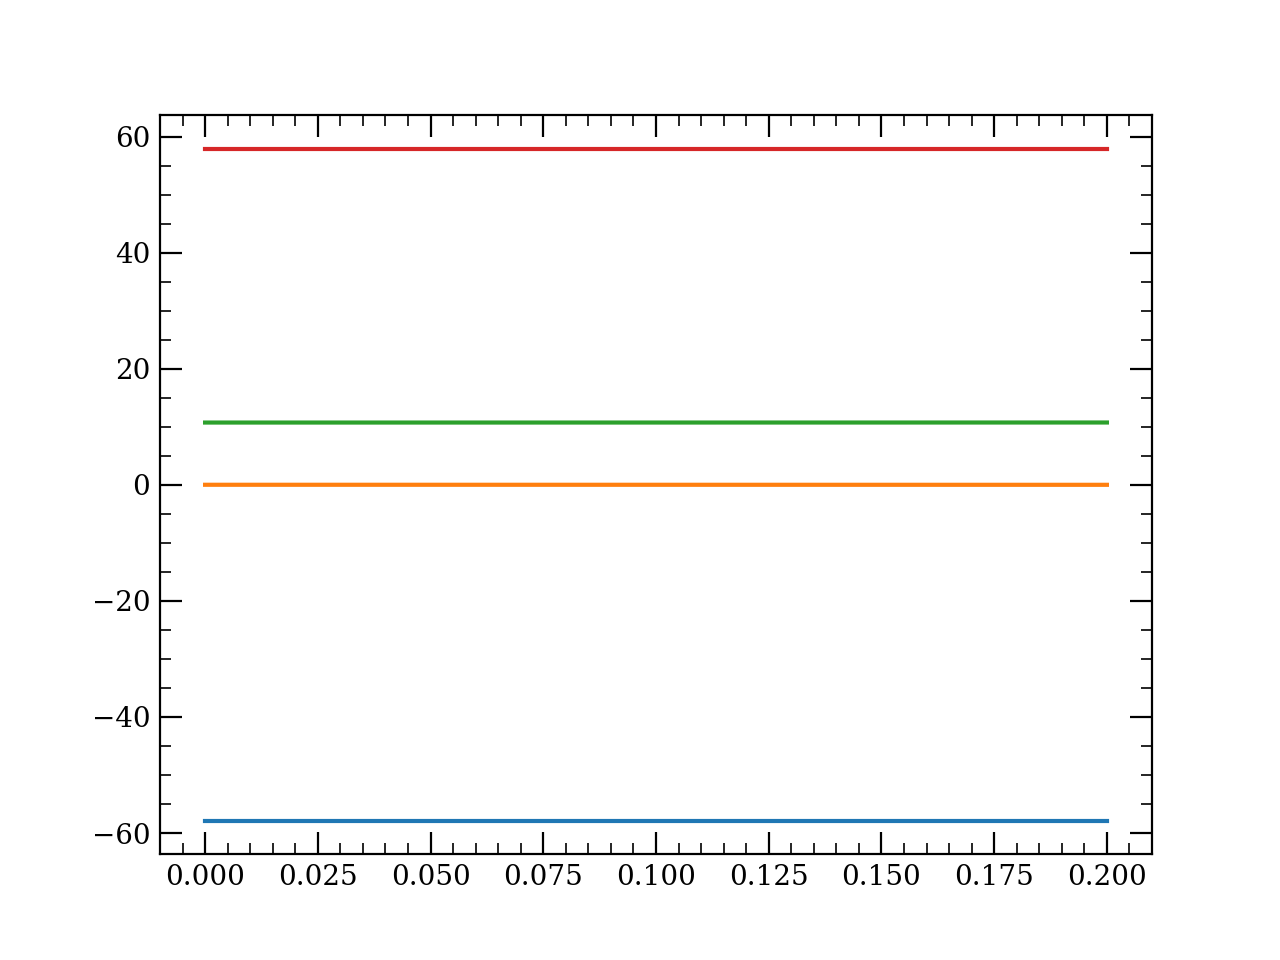

<IPython.core.display.Javascript object>


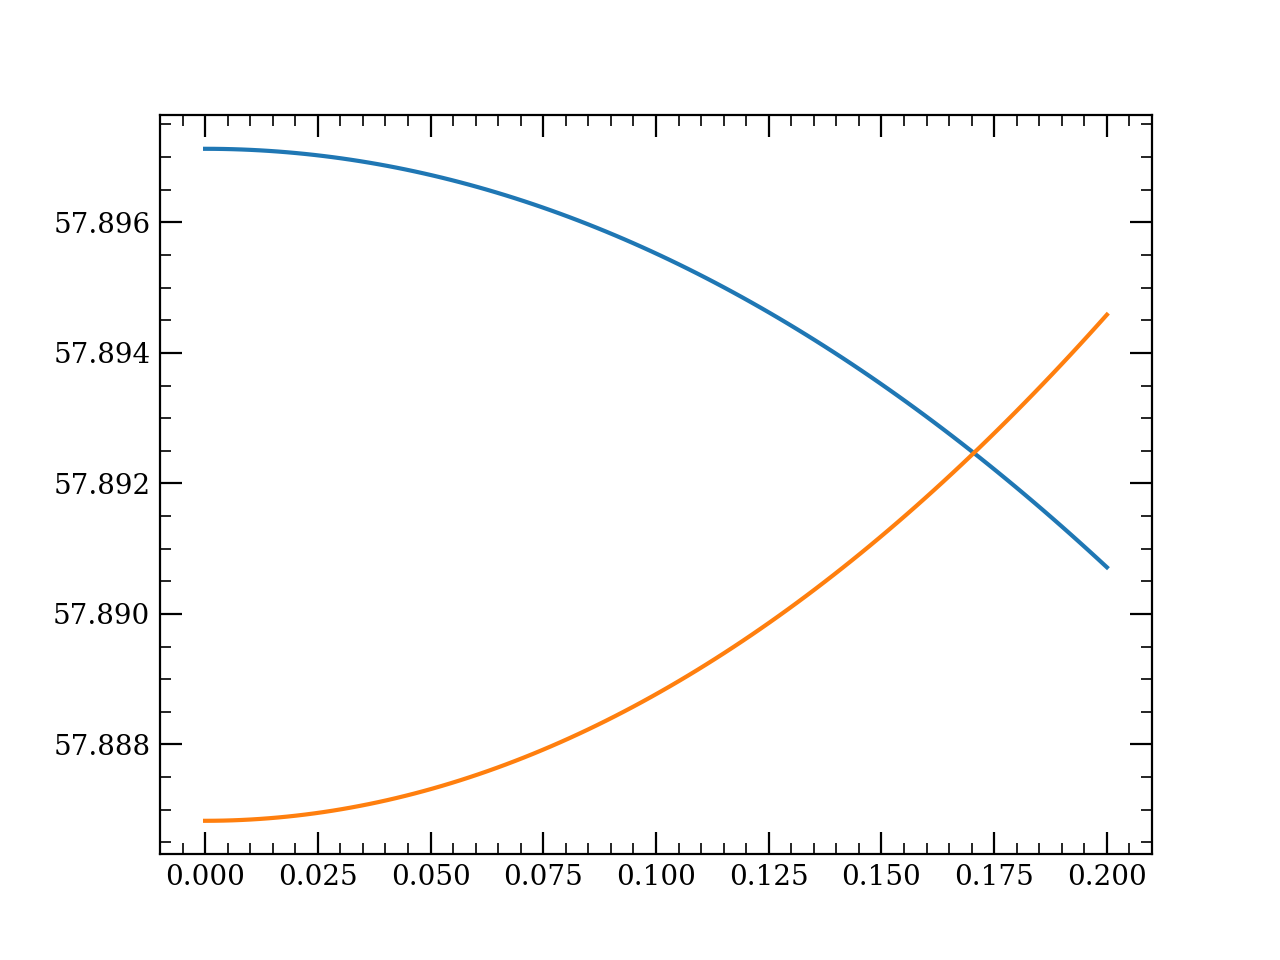

In [15]:
# state1 = [42,1,1.5,0.5]
# state2 = [43,0,0.5,0.5]
# states = [state1,state2]

states = [
    [42,1,1.5,0.5],
    [43,0,0.5,0.5],
    [42,0,0.5,0.5],
#     [43,1,1.5,0.5],
#     [44,0,0.5,0.5]
    [41,2,2.5,0.5],
#     [41,2,1.5,0.5]
]

# states = [
#     [41,1,1.5,0.5],
#     [42,0,0.5,0.5],
#     [41,0,0.5,0.5],
# #     [43,1,1.5,0.5],
# #     [44,0,0.5,0.5]
#     [40,2,2.5,0.5],
# #     [41,2,1.5,0.5]
# ]

Es = np.linspace(0,0.2,100)

H_Es = H_E_test(states, Es)

print(H_Es[-1])

energies = []

for H in H_Es:
    eigvals, eigvecs = eig(H)
    energies.append(np.sort(eigvals))
energies = np.transpose(energies)

plt.figure()
# plt.ylim(-0.05,0.05)
for energy in energies:
    plt.plot(Es, energy)

plt.figure()
plt.plot(Es, energies[1] - energies[0])
plt.plot(Es, energies[3] - energies[1])

In [16]:
def Forster_E_sensitivity(n, Es):
    states = [
        [n,1,1.5,0.5],
        [n+1,0,0.5,0.5],
        [n,0,0.5,0.5],
        [n-1,2,2.5,0.5],
    ]

    H_Es = H_E_test(states, Es)

    energies = []

    for H in H_Es:
        eigvals, eigvecs = eig(H)
        energies.append(np.sort(eigvals))
    energies = np.transpose(energies)

    D = 2*energies[1] - energies[0] - energies[-1]
    dE = Es[1]-Es[0]
    dDdE = np.gradient(D, dE)

    E_Forster_ind = np.argsort(np.abs(D))[0]
    print(f"n = {n}, {np.round(np.real(dDdE[E_Forster_ind]),3)} MHz/ mV/cm sensitivity")
    print(f"at the Forster resonance: {np.round(Es[E_Forster_ind],3)} V/cm")

    return(D, np.round(np.abs(dDdE[E_Forster_ind]),3))


n = 39, -0.444 MHz/ mV/cm sensitivity
at the Forster resonance: 1.126 V/cm
n = 40, -0.383 MHz/ mV/cm sensitivity
at the Forster resonance: 0.794 V/cm
n = 41, -0.294 MHz/ mV/cm sensitivity
at the Forster resonance: 0.503 V/cm
n = 42, -0.121 MHz/ mV/cm sensitivity
at the Forster resonance: 0.171 V/cm


<IPython.core.display.Javascript object>


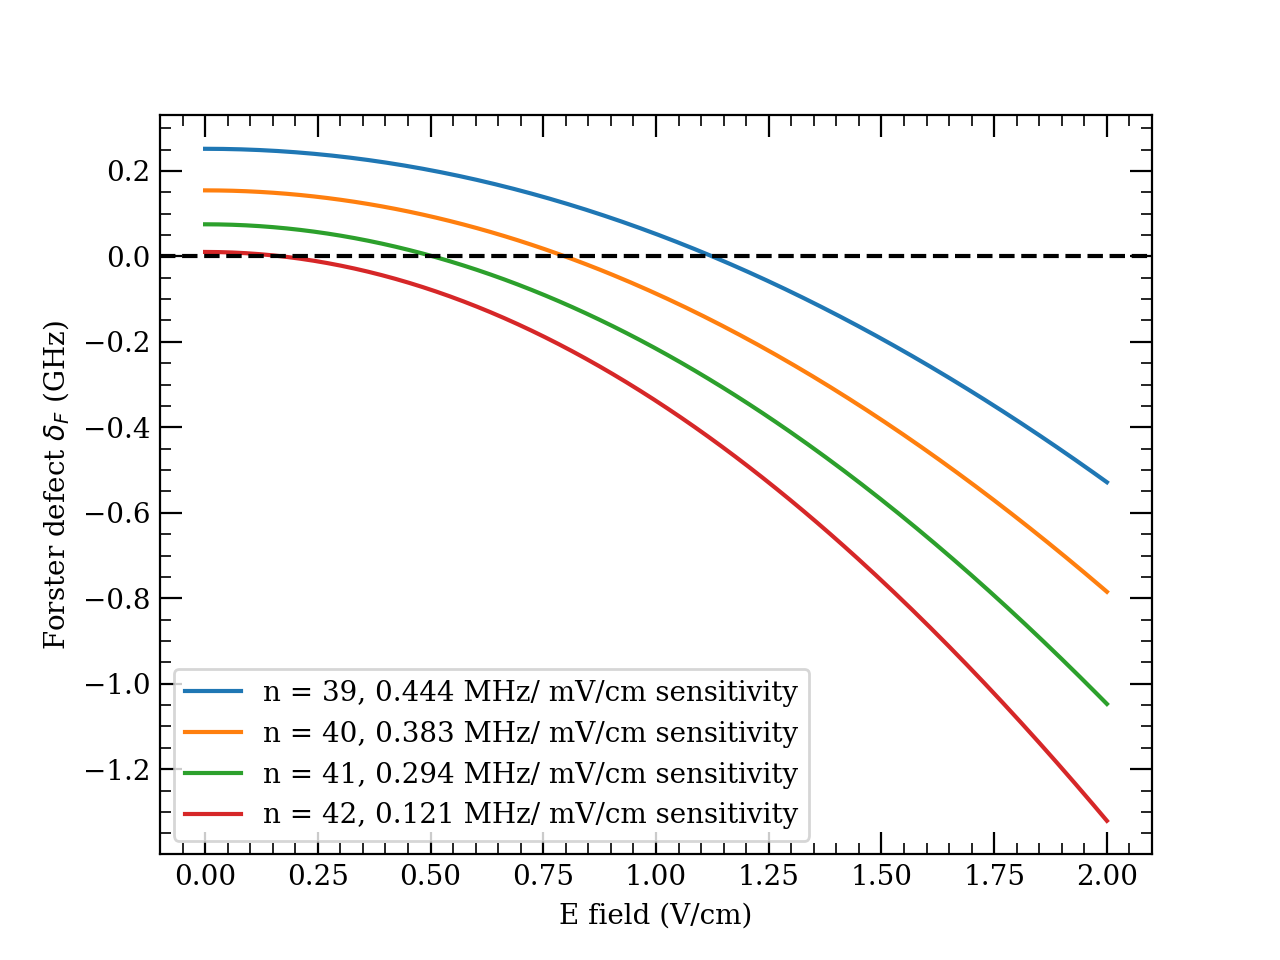

In [17]:
Es = np.linspace(0,2,200)
ns = [39, 40, 41, 42]

Ds = []
sensitivities = []
for n in ns:
    D, s = Forster_E_sensitivity(n, Es)
    Ds.append(D)
    sensitivities.append(s)

plt.figure()

for i, D in enumerate(Ds):
    plt.plot(Es, D, label = f"n = {ns[i]}, {sensitivities[i]} MHz/ mV/cm sensitivity")
plt.legend()
plt.xlabel("E field (V/cm)")
plt.ylabel(r"Forster defect $\delta_F$ (GHz)")
plt.axhline(y = 0, color = 'k', linestyle = '--') 

-0.384 MHz/ mV/cm sensitivity at the Forster resonance: 0.798 V/cm


<IPython.core.display.Javascript object>


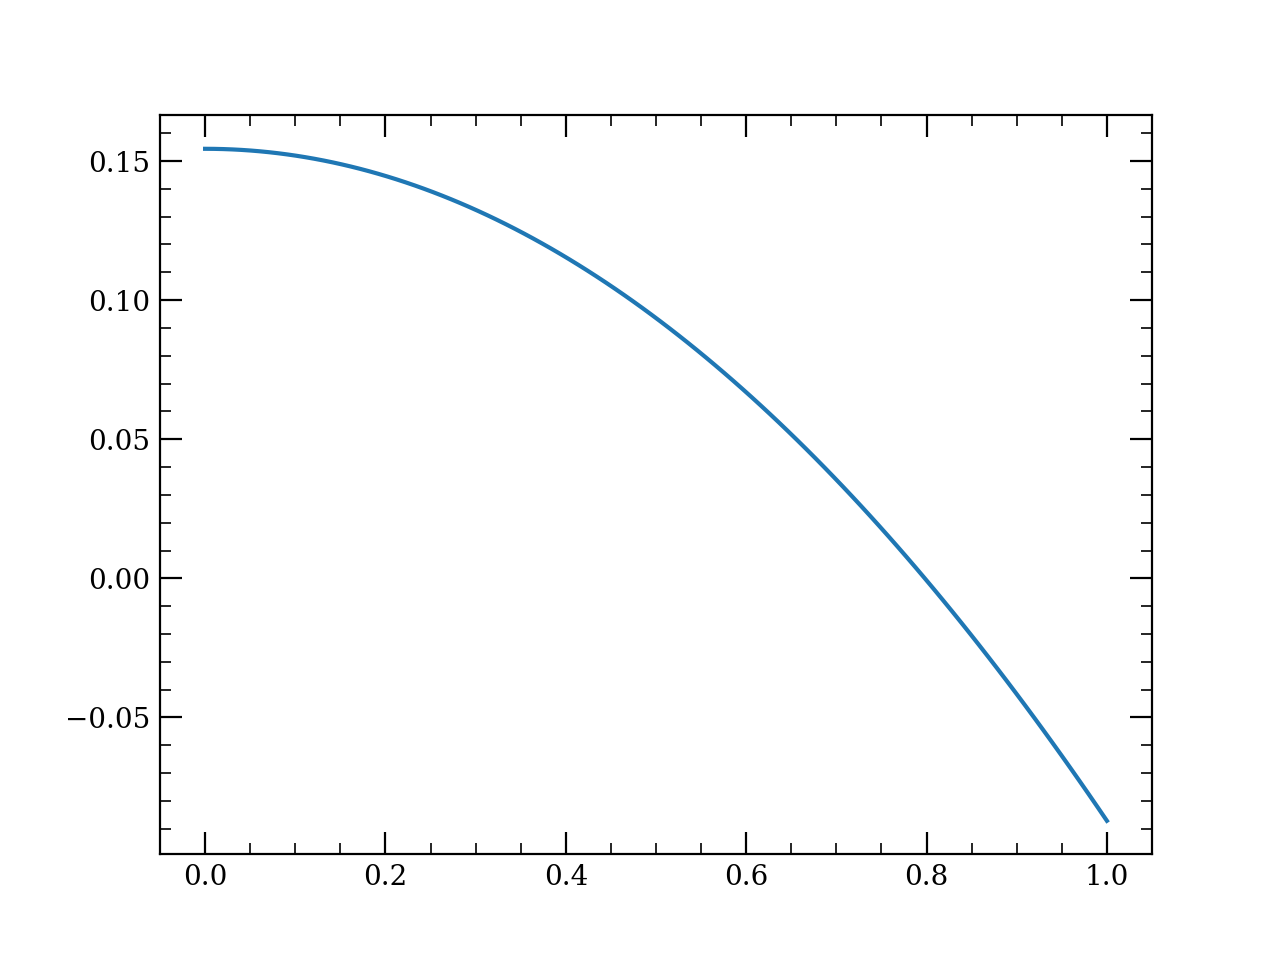

In [18]:
n = 40
states = [
    [n,1,1.5,0.5],
    [n+1,0,0.5,0.5],
    [n,0,0.5,0.5],
#     [43,1,1.5,0.5],
#     [44,0,0.5,0.5]
    [n-1,2,2.5,0.5],
#     [41,2,1.5,0.5]
]

# states = [[45,44,44.5,44.5],
#          [44,43,43.5,43.5]]

Es = np.linspace(0,1,100)

H_Es = H_E_test(states, Es)

# print(H_Es[-1])

energies = []

for H in H_Es:
    eigvals, eigvecs = eig(H)
    energies.append(np.sort(eigvals))
energies = np.transpose(energies)

D = 2*energies[1] - energies[0] - energies[-1]
dE = Es[1]-Es[0]
dDdE = np.gradient(D, dE)

E_Forster_ind = np.argsort(np.abs(D))[0]
print(f"{np.round(np.real(dDdE[E_Forster_ind]),3)} MHz/ mV/cm sensitivity at the Forster resonance: {np.round(Es[E_Forster_ind],3)} V/cm")

plt.figure()
plt.plot(Es, D)


## B Field Coupling

Zeeman shift due to $B\hat{z}$ in GHz

In [19]:
def V_b_coupling(state, B):
    #B in Gauss
    n,l,j,mj = state
    s = 1/2
    
    prefactor = physical_constants["Bohr magneton"][0] * B/10000
    gs = -physical_constants["electron g factor"][0]
    sumOverMl = 0

    for ml in np.linspace(mj - s, mj + s, round(2 * s + 1)):
        if abs(ml) <= l + 0.1:
            ms = mj - ml
            sumOverMl += (ml + gs * ms) * abs(CG(l, ml, s, ms, j, mj)) ** 2
    return prefactor * sumOverMl / C_h * 1.0e-9

In [20]:
Cs = Caesium()
state = [6,1,1.5,0.5]
B = 1

print(V_b_coupling(state, B))
print(Cs.getZeemanEnergyShift(state[1],state[2],state[3],B,s=1/2,) / C_h * 1.0e-9)

0.0009336240216038417
9.336240216038416


## Dipole-Dipole Interaction

Matrix element $\langle n,l,j,m_{j},nn,ll,jj,mm_{j} | V_{dd} | n_1,l_1,j_1,m_{1,j},n_2,l_2,j_2,m_{2,j}\rangle$ where we decompose $V_{dd}$ into a radial component

$e^2\hat{r}_1\hat{r}_2$ 

and an angular component

$Y_{1,-1}(\hat{\theta_1},\hat{\phi}_1)Y_{1,1}(\hat{\theta}_2,\hat{\phi}_2) + 2 Y_{1,0}(\hat{\theta}_1,\hat{\phi}_1)Y_{1,0}(\hat{\theta}_2,\hat{\phi}_2) + Y_{1,1}(\hat{\theta_1},\hat{\phi}_1)Y_{1,-1}(\hat{\theta}_2,\hat{\phi}_2)$.

This is assuming only first order (in the multipole expansion) dipole-dipole interactions, or the term setting $\kappa_1 = \kappa_2 = 1$ in Eq. 7 of arxiv.org/pdf/1612.08053.pdf.

The radial component is calculated with ARC, and the angular components are decomposed using the Wigner–Eckart theorem (the $Y_{\kappa,q}(\hat{\theta}_i,\hat{\phi}_i)$ above are not L-S coupled spherical harmonics, but our atoms are described by states $| n,l,j,m_{j}\rangle$).

In [21]:
Cs_integrals = Caesium()

def DD_coupling_radial_integral(pairstate1, pairstate2):
#     n,l,j,mj,nn,ll,jj,mmj = pairstate1
#     n1,l1,j1,mj1,n2,l2,j2,mj2 = pairstate2
    
    state11, state12 = pairstate1
    state21, state22 = pairstate2
    
    n_11, l_11, j_11, mj_11 = state11
    n_12, l_12, j_12, mj_12 = state12
    n_21, l_21, j_21, mj_21 = state21
    n_22, l_22, j_22, mj_22 = state22
    
    radial1 = Cs_integrals.getRadialCoupling(n_11, l_11, j_11, n_21, l_21, j_21, s=1/2)
    radial2 = Cs_integrals.getRadialCoupling(n_12, l_12, j_12, n_22, l_22, j_22, s=1/2)
        
    radial_coupling = (
        C_e**2
        / (4.0 * pi * epsilon_0)
        * radial1
        * radial2
        * (physical_constants["Bohr radius"][0]) ** 2
    )
#     print(radial_coupling / C_h)
    return radial_coupling / C_h * 1.0e-9 * (1.0e6) ** 3# GHz*um^3



def DD_coupling_angular_integral(state1, state2, q):
    n,l,j,mj = state1
    n1,l1,j1,mj1 = state2
    s = 1/2
    
    prefactor = (
        (-1)**(j-mj+2*l+s+j1+1)
        * np.sqrt((2*j+1)*(2*j1+1))
        *np.sqrt((2*l+1)*(2*l1+1)*3/(4*np.pi))
    )
    try:
        wigners = (
            Wigner3j(j, 1, j1, -mj, q, mj1)
            *Wigner6j(l, s, j, j1, 1, l1)
            *Wigner3j(l, 1, l1, 0, 0, 0)
        )
    except:
        wigners = 0
#     print(Wigner3j(j, 1, j1, -mj, q, mj1), Wigner6j(l, s, j, j1, 1, l1), Wigner3j(l, 1, l1, 0, 0, 0))
    
    return prefactor*wigners


def V_dd_coupling_aligned(pairstate1, pairstate2):
    #r must be in um
    
#     radial = DD_coupling_radial_integral(pairstate1, pairstate2)    
    #<pairstate1|V_dd|pairstate2>
    
    state11, state12 = pairstate1
    state21, state22 = pairstate2
    
#     print(state11, state12, state21, state22)
    
    angular = -4*np.pi/3*(
        DD_coupling_angular_integral(state11, state21, -1)*DD_coupling_angular_integral(state12, state22, 1)
        + 2*DD_coupling_angular_integral(state11, state21, 0)*DD_coupling_angular_integral(state12, state22, 0)
        + DD_coupling_angular_integral(state11, state21, 1)*DD_coupling_angular_integral(state12, state22, -1)
    )
    
    if np.abs(angular)<0.001:
        radial = 0
    else:
        radial = DD_coupling_radial_integral(pairstate1, pairstate2)
    
#     print(angular)
    return radial*angular# GHz*um^3

# def V_dd_coupling(pairstate1, pairstate2, r, θ):
#     if θ<0.01:
#         return V_dd_coupling_aligned(pairstate1, pairstate2, r)
#     else:
#         stuff

## Angular Component Debugging

Might be useful later when looking at nonzero $\theta$

In [22]:
def fcoef(l1, l2, m):
    return (
        factorial(l1 + l2)
        / (
            factorial(l1 + m)
            * factorial(l1 - m)
            * factorial(l2 + m)
            * factorial(l2 - m)
        )
        ** 0.5
    )

interactionsUpTo = 1
x = interactionsUpTo
fcp = np.zeros((x + 1, x + 1, 2 * x + 1))
for c1 in range(1, x + 1):
    for c2 in range(1, x + 1):
        for p in range(-min(c1, c2), min(c1, c2) + 1):
            fcp[c1, c2, p + x] = fcoef(c1, c2, p)

def getAngularMatrix_M(l, j, ll, jj, l1, j1, l2, j2):
    s = 1/2
    
    dl = abs(l - l1)
    dj = abs(j - j1)
    c1 = 0
    if dl == 1 and (dj < 1.1):
        c1 = 1  # dipole coupling
    elif dl == 0 or dl == 2 or dl == 1:
        c1 = 2  # quadrupole coupling
    else:
        raise ValueError("error in __getAngularMatrix_M")

    dl = abs(ll - l2)
    dj = abs(jj - j2)
    c2 = 0
    if dl == 1 and (dj < 1.1):
        c2 = 1  # dipole coupling
    elif dl == 0 or dl == 2 or dl == 1:
        c2 = 2  # quadrupole coupling
    else:
        raise ValueError("error in __getAngularMatrix_M")

    am = np.zeros(
        (
            round((2 * j1 + 1) * (2 * j2 + 1)),
            round((2 * j + 1) * (2 * jj + 1)),
        ),
        dtype=np.float64,
    )

    if (c1 > interactionsUpTo) or (c2 > interactionsUpTo):
        return am

    j1range = np.linspace(-j1, j1, round(2 * j1) + 1)
    j2range = np.linspace(-j2, j2, round(2 * j2) + 1)
    jrange = np.linspace(-j, j, round(2 * j) + 1)
    jjrange = np.linspace(-jj, jj, round(2 * jj) + 1)

    for m1 in j1range:
        for m2 in j2range:
            # we have chosen the first index
            index1 = round(
                m1 * (2.0 * j2 + 1.0) + m2 + (j1 * (2.0 * j2 + 1.0) + j2)
            )
            for m in jrange:
                for mm in jjrange:
                    # we have chosen the second index
                    index2 = round(
                        m * (2.0 * jj + 1.0)
                        + mm
                        + (j * (2.0 * jj + 1.0) + jj)
                    )

                    # angular matrix element from Sa??mannshausen, Heiner,
                    # Merkt, Fr??d??ric, Deiglmayr, Johannes
                    # PRA 92: 032505 (2015)
                    elem = (
                        (-1.0) ** (j + jj + s + s + l1 + l2)
                        * CG(l, 0, c1, 0, l1, 0)
                        * CG(ll, 0, c2, 0, l2, 0)
                    )
                    elem = (
                        elem
                        * np.sqrt((2.0 * l + 1.0) * (2.0 * ll + 1.0))
                        * np.sqrt((2.0 * j + 1.0) * (2.0 * jj + 1.0))
                    )
                    elem = (
                        elem
                        * Wigner6j(l, s, j, j1, c1, l1)
                        * Wigner6j(ll, s, jj, j2, c2, l2)
                    )

                    sumPol = 0.0  # sum over polarisations
                    limit = min(c1, c2)
                    for p in range(-limit, limit + 1):
                        sumPol = sumPol + fcp[
                            c1, c2, p + interactionsUpTo
                        ] * CG(j, m, c1, p, j1, m1) * CG(
                            jj, mm, c2, -p, j2, m2
                        )
                    am[index1, index2] = elem * sumPol
    return am

In [23]:
state11 = [42,1,1.5,0.5]
state12 = [43,0,0.5,0.5]
state21 = [43,0,0.5,0.5]
state22 = [42,1,1.5,0.5]

pairstate1 = [state11, state12]
pairstate2 = [state21, state22]

pairstates = [pairstate1, pairstate2]
print(np.shape(pairstates))

# print(C_e**2 / (4.0 * pi * epsilon_0))

V_dd_coupling_aligned(pairstate1, pairstate2)


# arc_calc = PairStateInteractions(
#     Caesium(), 
#     state11[0], state11[1], state11[2], 
#     state12[0], state12[1], state12[2], 
#     state11[3], state12[3], interactionsUpTo=1
# )
# arc_calc.defineBasis(0, 0, 1, 1, 10, Bz=0, progressOutput=False, debugOutput=False)

arc_val = getAngularMatrix_M(state11[1], state11[2],
                             state12[1], state12[2],
                             state21[1], state21[2],
                             state22[1], state22[2])

print(arc_val)

(2, 2, 4)
[[-0.33333333 -0.         -0.         -0.         -0.         -0.
  -0.         -0.        ]
 [-0.         -0.19245009  0.44444444 -0.         -0.         -0.
  -0.         -0.        ]
 [-0.         -0.         -0.          0.44444444 -0.11111111 -0.
  -0.         -0.        ]
 [-0.         -0.         -0.         -0.         -0.         -0.19245009
  -0.         -0.        ]
 [-0.         -0.         -0.19245009 -0.         -0.         -0.
  -0.         -0.        ]
 [-0.         -0.         -0.         -0.11111111  0.44444444 -0.
  -0.         -0.        ]
 [-0.         -0.         -0.         -0.         -0.          0.44444444
  -0.19245009 -0.        ]
 [-0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.33333333]]


## Full Matrix Elements

Calculates matrix elements $\langle \psi_1 | \frac{H_{atom} + H_{E} + H_{B} + V_{dd}(r)}{h} | \psi_2 \rangle$ of the full Hamiltonian in GHz. Note that $H_{E} = H_{E,1} \otimes \mathbb{1} + \mathbb{1} \otimes H_{E,2}$

In [33]:
Cs_matrixElement = Caesium()

def MatrixElement(pairstate1, pairstate2, B, E, r, ω_0):
    state11, state12 = pairstate1
    state21, state22 = pairstate2
        
    if pairstate1==pairstate2:
        n_1, l_1, j_1, mj_1 = state11
        n_2, l_2, j_2, mj_2 = state12
        ω = (Cs_matrixElement.getEnergy(n_1, l_1, j_1) + 
             Cs_matrixElement.getEnergy(n_2, l_2, j_2))*C_e/C_h*1e-9# eV to GHz*h
        Zeeman = V_b_coupling(state11, B) + V_b_coupling(state12, B)
        
#         print(ω + Zeeman - ω_0)
        
        return (ω + Zeeman - ω_0)
    
    else:
        if state12==state22:
            Stark_shift = V_e_coupling(state11, state21, E)
        elif state11==state21:
            Stark_shift = V_e_coupling(state12, state22, E)
        else:
            Stark_shift = 0
        dipole_dipole = V_dd_coupling_aligned(pairstate1, pairstate2)
        
#         print(pairstate1, pairstate2, Stark_shift, state12==state22)    
    
        if np.size(r)==1:
            return(-Stark_shift + dipole_dipole / r**3)
        else:
            return([-Stark_shift + dipole_dipole / rr**3 for rr in r])
            
    
def make_Hamiltonian_DUMB(states, B, E, r):
    pairstates = []
    for state1 in states:
        for state2 in states:
            pairstates.append([state1,state2])
    d = np.shape(pairstates)[0]
    
    Hs = [np.array([[0.0 for i in range(d)] for j in range(d)]) for k in range(np.size(r))]

    state0 = states[0]
    n_0, l_0, j_0, mj_0 = state0
    ω_0 = 2*Cs_matrixElement.getEnergy(n_0, l_0, j_0)*C_e/C_h*1e-9#eV to GHz*h

    for i, pairstate1 in enumerate(pairstates):
        for j, pairstate2 in enumerate(pairstates):
            H_ij = MatrixElement(pairstate1, pairstate2, B, E, r, ω_0)
#             print(H_ij)
            for r_ind, H in enumerate(Hs):
                if np.size(H_ij)==1:
                        H[i][j]+=H_ij
                else:
                    H[i][j]+=H_ij[r_ind]

    return Hs, pairstates

def make_Hamiltonian_DUMB_pairstates(pairstates, pairstate0, B, E, r):
    d = np.shape(pairstates)[0]
    
    Hs = [np.array([[0.0 for i in range(d)] for j in range(d)]) for k in range(np.size(r))]

    state01, state02 = pairstate0
    n_1, l_1, j_1, mj_1 = state01
    n_2, l_2, j_2, mj_2 = state02
    ω_0 = (Cs_matrixElement.getEnergy(n_1, l_1, j_1) + 
         Cs_matrixElement.getEnergy(n_2, l_2, j_2))*C_e/C_h*1e-9# eV to GHz*h
#     print(ω_0)

    for i, pairstate1 in enumerate(pairstates):
        for j, pairstate2 in enumerate(pairstates):
            H_ij = MatrixElement(pairstate1, pairstate2, B, E, r, ω_0)
#             print(H_ij)
            for r_ind, H in enumerate(Hs):
                if np.size(H_ij)==1:
                        H[i][j]+=H_ij
                else:
                    H[i][j]+=H_ij[r_ind]

    return Hs

def pairstate_E(pairstate):
    state1, state2 = pairstate
    n_1, l_1, j_1, mj_1 = state1
    n_2, l_2, j_2, mj_2 = state2
    ω = (Cs_matrixElement.getEnergy(n_1, l_1, j_1) + 
         Cs_matrixElement.getEnergy(n_2, l_2, j_2))*C_e/C_h*1e-9# eV to GHz*h
    return ω



# def make_Hamiltonian(states, B, E, r):
#     pairstates = []
#     for state1 in states:
#         for state2 in states:
#             pairstates.append([state1,state2])
#     d = np.shape(pairstates)[0]
    
#     H = csr_matrix((d, d))

#     state0 = states[0]
#     n_0, l_0, j_0, mj_0 = state0
#     ω_0 = 2*Caesium().getEnergy(n_0, l_0, j_0)*C_e/C_h*1e-9#eV to GHz*h
    

## Some Small Systems

In [25]:
# state11 = [42,1,1.5,0.5]
# state12 = [43,0,0.5,0.5]
# state21 = [42,0,0.5,0.5]

# states = [state11, state12, state21]
states = [
    [42,1,1.5,0.5],
    [43,0,0.5,0.5],
    [42,0,0.5,0.5],
    [42,1,1.5,1.5],
    [42,1,1.5,-0.5]
]

# pairstates = [[[42,1,1.5,-0.5],[42,1,1.5,1.5]], 
#               [[42,1,1.5,1.5],[42,1,1.5,-0.5]],
#               [[43,0,0.5,0.5],[42,0,0.5,0.5]], 
#               [[42,0,0.5,0.5],[43,0,0.5,0.5]],
#               [[42,1,1.5,0.5],[41,2,2.5,0.5]],
#               [[42,2,2.5,0.5],[42,1,1.5,0.5]],
# #               [[42,1,1.5,0.5],[43,0,0.5,0.5]],
# #               [[43,0,0.5,0.5],[42,1,1.5,0.5]],
# ]
n = 42
pairstates = [[[n,1,1.5,0.5],[n,1,1.5,0.5]], 
              [[n+1,0,0.5,0.5],[n,0,0.5,0.5]], 
              [[n,0,0.5,0.5],[n+1,0,0.5,0.5]],
              [[n,1,1.5,0.5],[n-1,2,2.5,0.5]],
              [[n-1,2,2.5,0.5],[n,1,1.5,0.5]],
#               [[n,1,1.5,-0.5],[n,1,1.5,1.5]],
#               [[n,1,1.5,1.5],[n,1,1.5,0.5]],
]
print(pairstates)

rs = np.linspace(5,20,100)

H_test_pairstates_0 = make_Hamiltonian_DUMB_pairstates(pairstates, pairstates[0], 0, 0, rs)
print(H_test_pairstates_0[0])
# H_test, pairstates = make_Hamiltonian_DUMB(states, 0, 0, rs)

[[[42, 1, 1.5, 0.5], [42, 1, 1.5, 0.5]], [[43, 0, 0.5, 0.5], [42, 0, 0.5, 0.5]], [[42, 0, 0.5, 0.5], [43, 0, 0.5, 0.5]], [[42, 1, 1.5, 0.5], [41, 2, 2.5, 0.5]], [[41, 2, 2.5, 0.5], [42, 1, 1.5, 0.5]]]
[[ 0.00000000e+00 -9.25301443e-03 -9.25301443e-03  0.00000000e+00
   0.00000000e+00]
 [-9.25301443e-03 -1.02956465e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-9.25301443e-03  0.00000000e+00 -1.02956465e-02  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.07219796e+01
  -1.82161895e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.82161895e-02
   1.07219796e+01]]


<IPython.core.display.Javascript object>


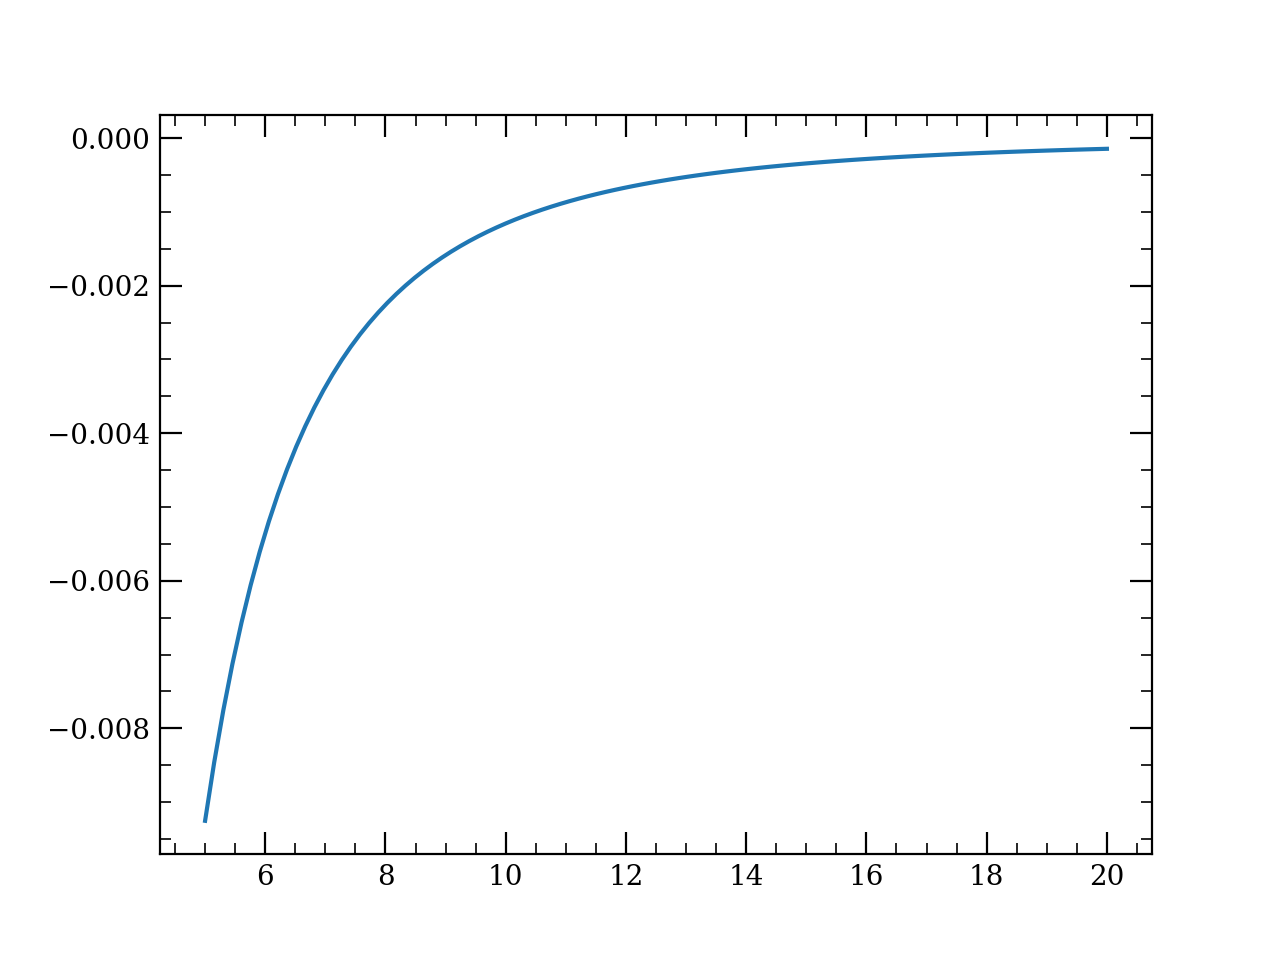

In [26]:
plt.figure()
plt.plot(rs, [H_test_pairstates_0[i][0][1] for i in range(np.shape(H_test_pairstates_0)[0])])

J_00 = np.array([H_test_pairstates_0[i][0][1] for i in range(np.shape(H_test_pairstates_0)[0])])

<IPython.core.display.Javascript object>


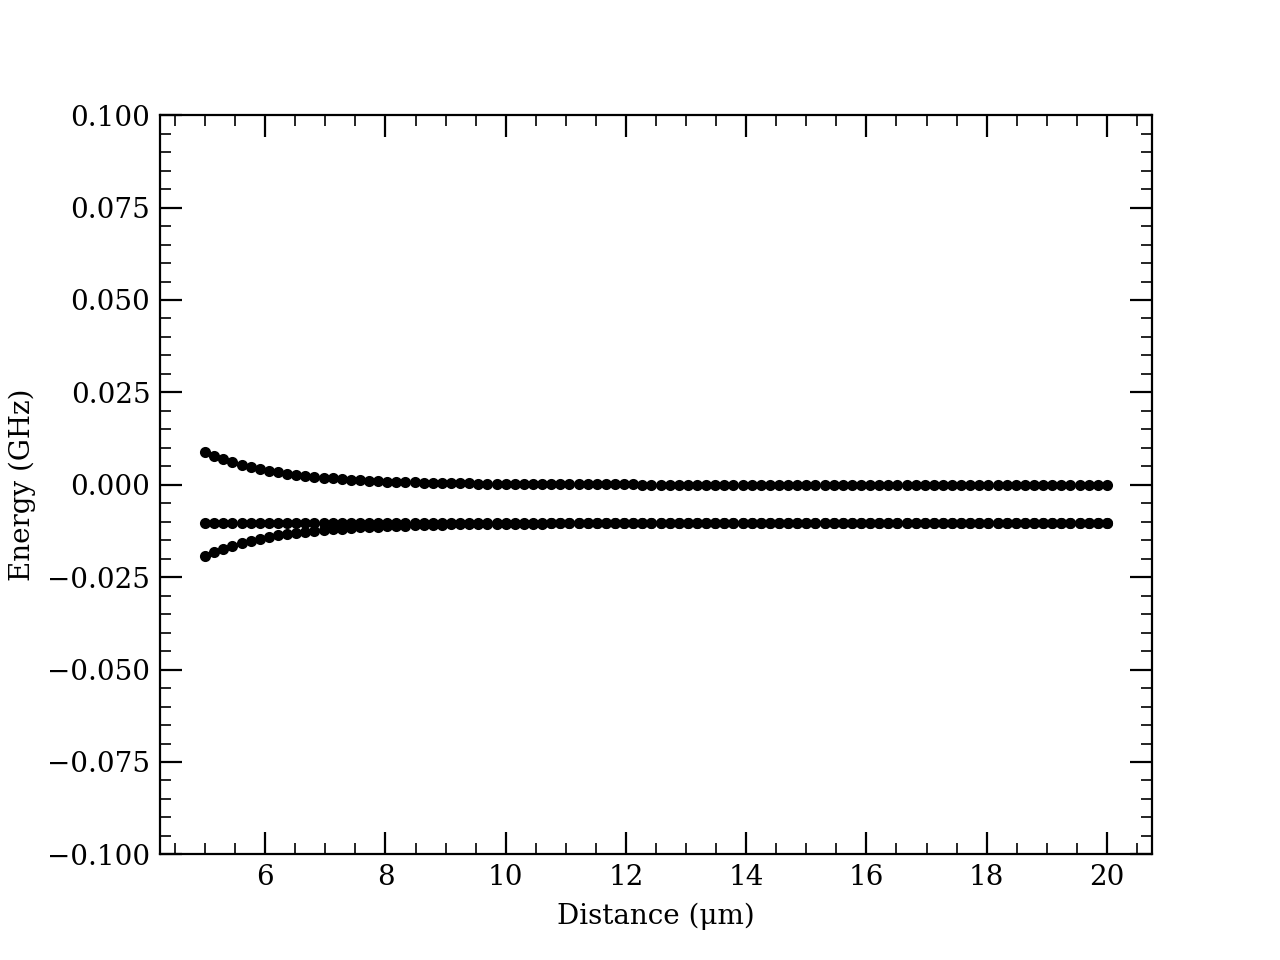

Text(0, 0.5, 'Energy (GHz)')

In [27]:
energies = []

# for H in H_test:
#     eigvals, eigvecs = eig(H)
#     energies.append(eigvals)
# energies = np.transpose(energies)

for H in H_test_pairstates_0:
    eigvals, eigvecs = eig(H)
    energies.append(np.sort(eigvals))
energies = np.transpose(energies)

plt.figure()
plt.ylim(-0.1, 0.1)

# print(energies)
for energy in energies:
    plt.plot(rs, energy, "k.")

plt.xlabel('Distance (μm)')
plt.ylabel('Energy (GHz)')    

# plt.figure()
# plt.plot(rs,np.abs(energies[0] - energies[0][-1]))
# plt.plot(rs,np.abs(energies[2] - energies[2][-1]))
# plt.xlabel('Distance (μm)')
# plt.ylabel('Energy Shift (GHz)')

In [28]:
n = 42
pairstates = [[[n,1,1.5,0.5],[n,1,1.5,0.5]], 
              [[n+1,0,0.5,0.5],[n,0,0.5,0.5]], 
              [[n,0,0.5,0.5],[n+1,0,0.5,0.5]],
              [[n,1,1.5,0.5],[n-1,2,2.5,0.5]],
              [[n-1,2,2.5,0.5],[n,1,1.5,0.5]],
#               [[n,1,1.5,-0.5],[n,1,1.5,1.5]],
#               [[n,1,1.5,1.5],[n,1,1.5,0.5]],
]

rs = np.linspace(5,20,100)

Es = np.linspace(0.15,0.19,100)

pp_energies = []
D_vals = []
E_res = 0.17
D_over_pp_energies = []
for E in Es:
    H_test_pairstates = make_Hamiltonian_DUMB_pairstates(pairstates, pairstates[0], 0, E, rs)
    energies_E = []
    for H in H_test_pairstates:
        eigvals, eigvecs = eig(H)
        energies_E.append(np.sort(eigvals))
    energies_E = np.transpose(energies_E)
    pp_energies.append(np.abs(energies_E[0] - energies_E[0][-1]))
    if E<E_res:
        D_val = energies_E[2][-1] - energies_E[0][-1]
        D_vals.append(D_val)
        D_over_pp_energies.append(np.real(D_val)/np.abs(energies_E[0] - energies_E[0][-1]))
    else:
        D_val = energies_E[0][-1] - energies_E[2][-1]
        D_vals.append(D_val)
        D_over_pp_energies.append(np.real(D_val)/np.abs(energies_E[0] - energies_E[0][-1]))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide


In [17]:
J_00_over_D = []

for D_val in D_vals:
    temp = []
    for J0 in J_00:
#         print(J0)
        temp.append(J0/np.real(D_val))
    J_00_over_D.append(temp)
# print(J_00_over_D)

<IPython.core.display.Javascript object>


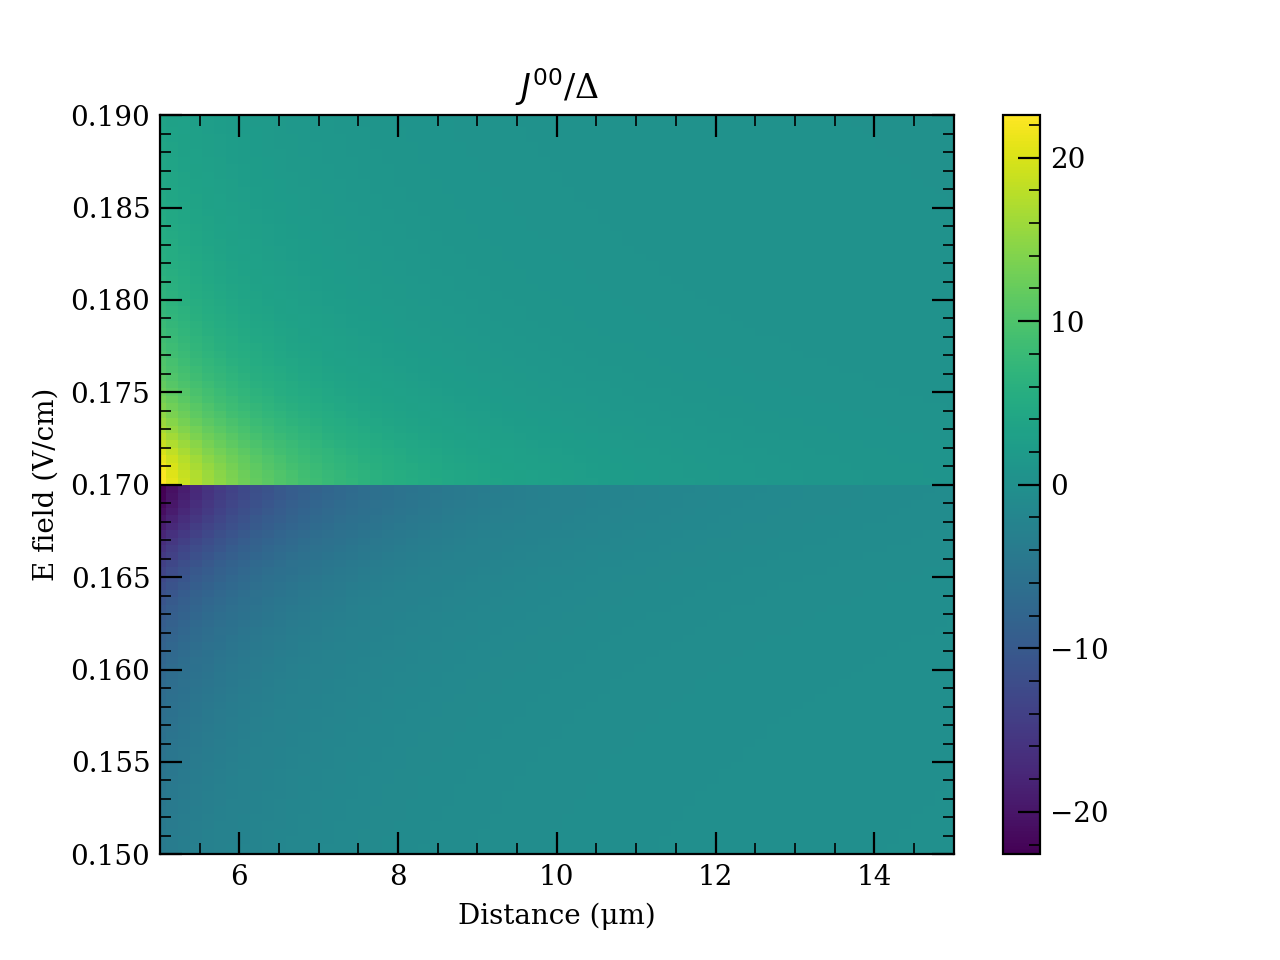

(0.15, 0.19)

In [18]:
# plt.figure()
# # plt.plot(Es, D_vals)
# plt.imshow(np.log(np.array(pp_energies)))

# im = np.log(np.abs(1/np.array(D_over_pp_energies)))
# im = 1/np.array(D_over_pp_energies)
# im = np.array(pp_energies)
im = np.array(J_00_over_D)

# print(D_vals)

fig,ax = plt.subplots()
c = ax.pcolor(rs, Es, im)
ax.set_title(r'$J^{00}$/Δ')
fig.colorbar(c)
ax.set_xlabel('Distance (μm)')
ax.set_ylabel('E field (V/cm)')
ax.set_xlim(5,15)
ax.set_ylim(0.15,0.19)

# plt.imshow(np.log(np.abs(1/np.array(D_over_pp_energies))))
# plt.colorbar()

## Some Bigger Systems

In [34]:
# def make_basis_align(state, Δn, Δl, ΔE):
#     stufff

states = [[42,1,1.5,0.5],
          [43,0,0.5,0.5],
          [42,0,0.5,0.5],
          [41,2,2.5,0.5],
          [42,1,1.5,-0.5],
          [42,1,1.5,1.5]]

# states = [[44,43,43.5,43.5],
#           [43,42,42.5,42.5],
#           [45,44,44.5,44.5]]

pairstate0 = [states[0], state[0]]

pairstates = []
for state1 in states:
    for state2 in states:
        pairstate = [state1,state2]
        if pairstate not in pairstates:
            pairstates.append(pairstate)
print(pairstates)

rs = np.linspace(2,20,100)

H_test_pairstates = make_Hamiltonian_DUMB_pairstates(pairstates, pairstate0, 0, 0, rs)
print(H_test_pairstates[-1])

[[[42, 1, 1.5, 0.5], [42, 1, 1.5, 0.5]], [[42, 1, 1.5, 0.5], [43, 0, 0.5, 0.5]], [[42, 1, 1.5, 0.5], [42, 0, 0.5, 0.5]], [[42, 1, 1.5, 0.5], [41, 2, 2.5, 0.5]], [[42, 1, 1.5, 0.5], [42, 1, 1.5, -0.5]], [[42, 1, 1.5, 0.5], [42, 1, 1.5, 1.5]], [[43, 0, 0.5, 0.5], [42, 1, 1.5, 0.5]], [[43, 0, 0.5, 0.5], [43, 0, 0.5, 0.5]], [[43, 0, 0.5, 0.5], [42, 0, 0.5, 0.5]], [[43, 0, 0.5, 0.5], [41, 2, 2.5, 0.5]], [[43, 0, 0.5, 0.5], [42, 1, 1.5, -0.5]], [[43, 0, 0.5, 0.5], [42, 1, 1.5, 1.5]], [[42, 0, 0.5, 0.5], [42, 1, 1.5, 0.5]], [[42, 0, 0.5, 0.5], [43, 0, 0.5, 0.5]], [[42, 0, 0.5, 0.5], [42, 0, 0.5, 0.5]], [[42, 0, 0.5, 0.5], [41, 2, 2.5, 0.5]], [[42, 0, 0.5, 0.5], [42, 1, 1.5, -0.5]], [[42, 0, 0.5, 0.5], [42, 1, 1.5, 1.5]], [[41, 2, 2.5, 0.5], [42, 1, 1.5, 0.5]], [[41, 2, 2.5, 0.5], [43, 0, 0.5, 0.5]], [[41, 2, 2.5, 0.5], [42, 0, 0.5, 0.5]], [[41, 2, 2.5, 0.5], [41, 2, 2.5, 0.5]], [[41, 2, 2.5, 0.5], [42, 1, 1.5, -0.5]], [[41, 2, 2.5, 0.5], [42, 1, 1.5, 1.5]], [[42, 1, 1.5, -0.5], [42, 1, 1.5, 0

TypeError: cannot unpack non-iterable int object

In [32]:
state = [42,1,1.5,0.5]
pairstate0 = [state, state]
pairstates = make_basis_align(state, 4, 4, 10)
print(np.shape(pairstates))

rs = np.linspace(2,20,100)

H_test_pairstates = make_Hamiltonian_DUMB_pairstates(pairstates, pairstate0, 0, 0, rs)
print(H_test_pairstates[-1])

NameError: name 'make_basis_align' is not defined

<IPython.core.display.Javascript object>


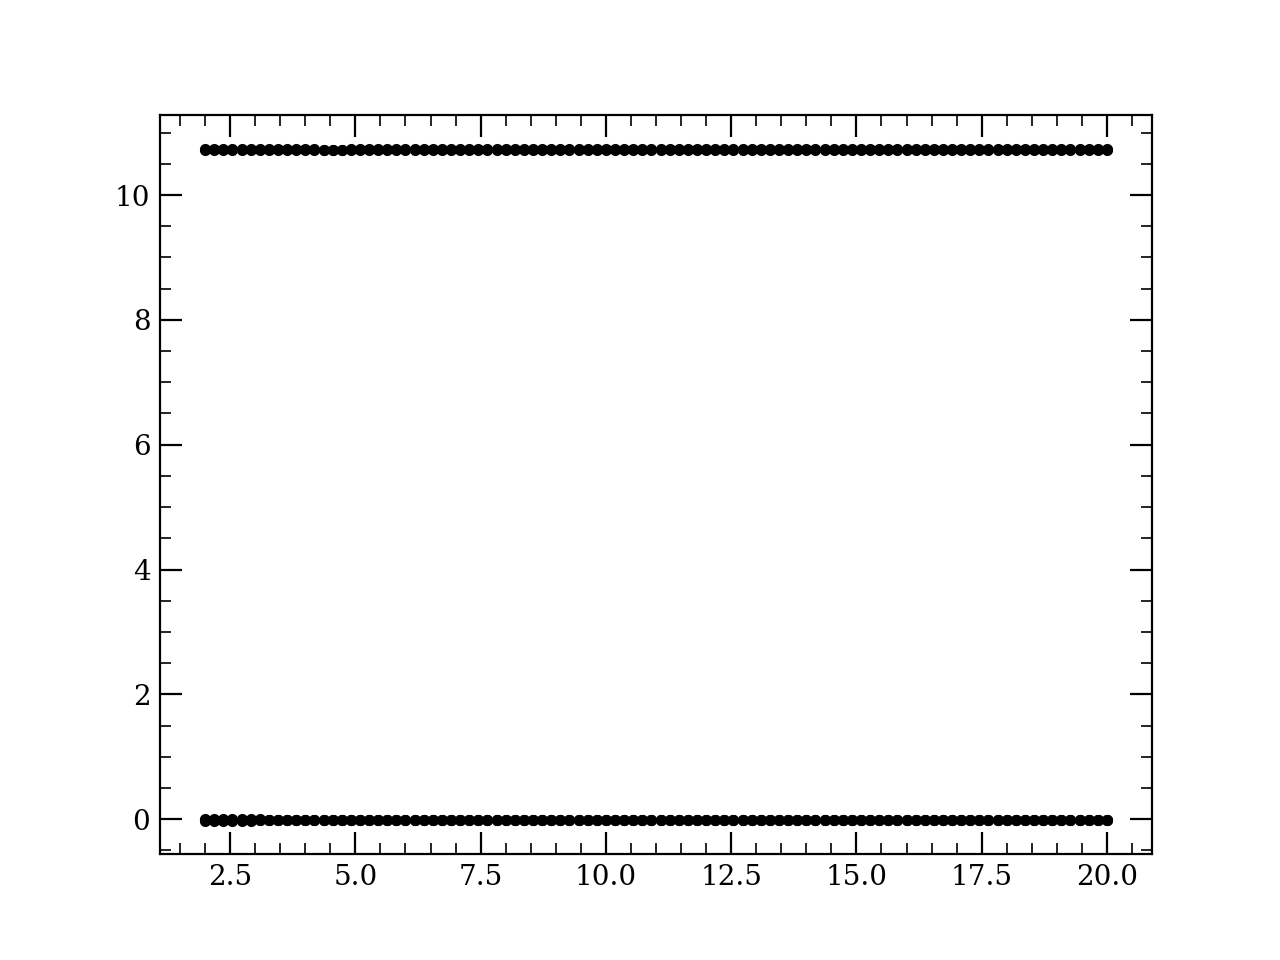

In [31]:
energies = []
for H in H_test_pairstates:
    eigvals, eigvecs = eig(H)
    energies.append(np.sort(eigvals))
energies = np.transpose(energies)

plt.figure()
# plt.ylim(-0.2, 0.1)

# print(energies)
for energy in energies:
    plt.plot(rs, energy,"k.")

### Picking out eigenstates with high overlap with basis state

In [20]:
# H_test_pairstates[0]
# pairstates

def extract_subsystem_matrix(H, pairstates, subsystem):
    array_tuples = np.array([tuple(np.concatenate((row[0],row[1]))) for row in pairstates])
    subset_tuples = np.array([tuple(np.concatenate((row[0],row[1]))) for row in subsystem])
    
#     print(array_tuples, subset_tuples)
    
    # Find the indices of the subset tuples in the array tuples
    indices = []
    for sub_tuple in subset_tuples:
        for a_tuple,i in zip(array_tuples, range(np.shape(array_tuples)[0])):
            if tuple(sub_tuple)==tuple(a_tuple):
                indices.append(i)
    
    # Remove duplicate indices
    unique_indices = np.unique(indices)
    
    subset_basis = unique_indices.tolist()
    
    subset_matrix = H[np.ix_(subset_basis, subset_basis)]
    return subset_matrix, subset_basis

def state_vec(pairstates, subsystem):
    array_tuples = np.array([tuple(np.concatenate((row[0],row[1]))) for row in pairstates])
    subset_tuples = np.array([tuple(np.concatenate((row[0],row[1]))) for row in subsystem])
    
#     print(array_tuples, subset_tuples)
    
    # Find the indices of the subset tuples in the array tuples
    indices = []
    index = 0
    for sub_tuple in subset_tuples:
        for a_tuple,i in zip(array_tuples, range(np.shape(array_tuples)[0])):
            if tuple(sub_tuple)==tuple(a_tuple):
#                 print(sub_tuple, a_tuple)
                indices.append(1)
                index = i
            else:
                indices.append(0)
    return indices

def max_overlap_states(H, state_vec, N):
    eigvals, vecs = np.linalg.eig(H)
    eigvecs = np.transpose(vecs)
    
#     print(eigvecs, state_vec)
    
    overlaps = [np.abs(np.dot(state_vec, v)) for v in eigvecs]
#     print(overlaps)
    highest_overlap_inds = np.argsort(overlaps)[-N:]
#     print(highest_overlap_inds)
    
    highest_overlap_eigvals = []
    highest_overlaps = []
    for ind in highest_overlap_inds:
        if np.abs(overlaps[ind])>1e-20:
            highest_overlap_eigvals.append(eigvals[ind])
            highest_overlaps.append(overlaps[ind])
#             if eigvals[ind]>10:
#                 print(eigvecs[ind])
    
    return highest_overlaps, highest_overlap_eigvals

def max_overlap_eigenstates(Hs, state_vec, N):
    eigs = []
    weights = []
    for H in Hs:
        w, e = max_overlap_states(H, state_vec, N)
        eigs.append(e)
        weights.append(w)
    return np.transpose(eigs), np.transpose(weights)

In [26]:
Hs = [[[1,2,1],[2,0,1],[1,1,d]] for d in range(-2,2)]
state_v = [0,1,0]
max_overlap_eigenstates(Hs, state_v, 2)

(array([[ 2.95934144,  3.04891734,  3.18194334,  3.38848975],
        [-1.53016771, -1.69202147, -1.58836399, -1.57577347]]),
 array([[0.60027549, 0.59100905, 0.57442663, 0.54411439],
        [0.73640681, 0.73697623, 0.80971228, 0.80236373]]))

(64, 2, 4)
[[  0.          -0.72690407  -0.74317516 ...   0.           0.
    0.        ]
 [ -0.72690407  67.87942453   0.         ...   0.           0.
    0.        ]
 [ -0.74317516   0.         -68.03381826 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...  12.58745754  -1.03151701
    0.        ]
 [  0.           0.           0.         ...  -1.03151701   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]


<IPython.core.display.Javascript object>


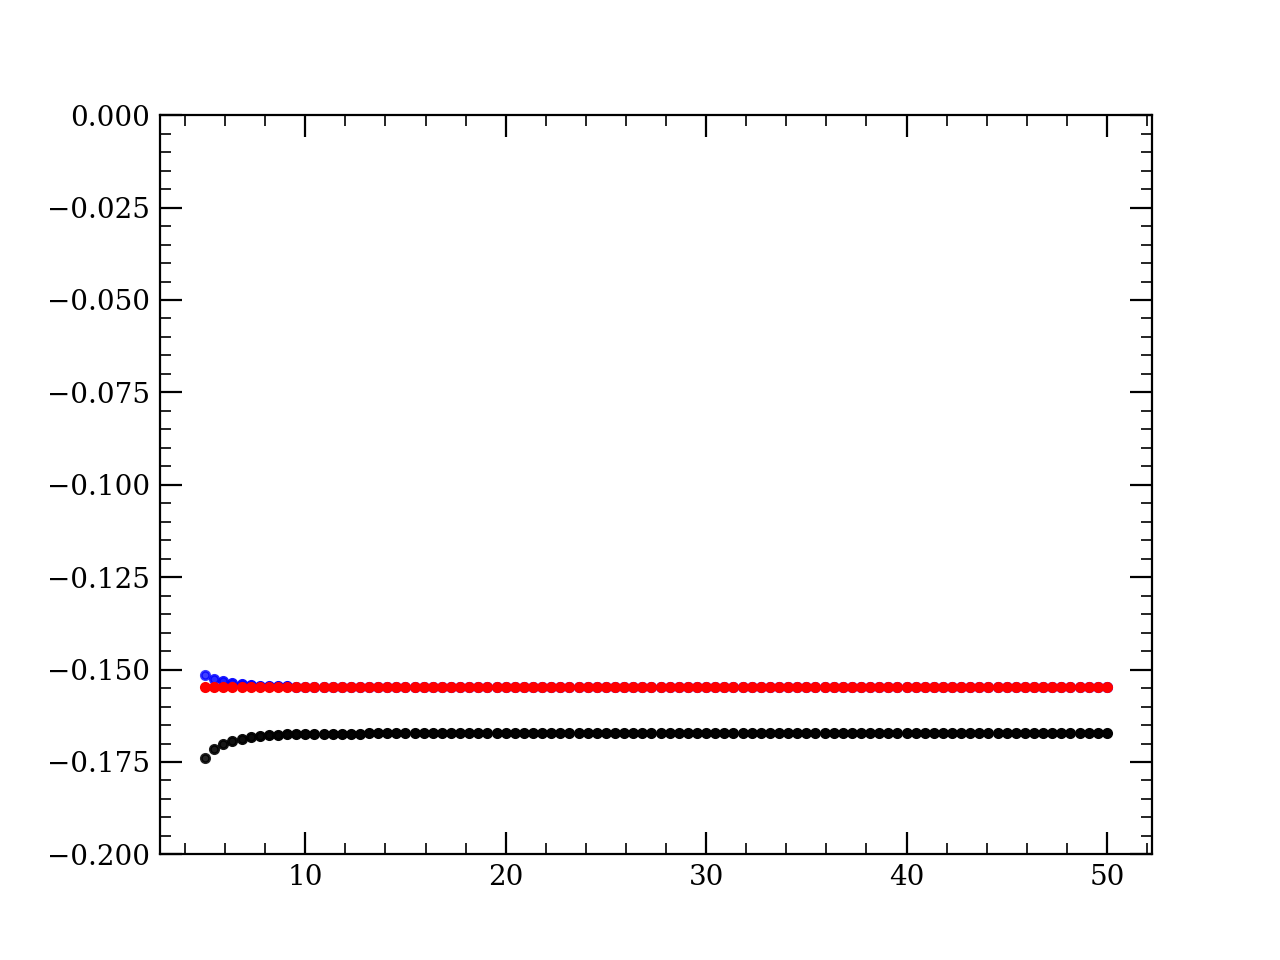

(-0.2, 0.0)

In [27]:
n = 40

states = [[n,1,1.5,0.5],
          [n+1,0,0.5,0.5],
          [n,0,0.5,0.5],
          [n-1,2,2.5,1.5],
          [n-1,2,2.5,0.5],
          [n-1,2,2.5,-0.5],
          [n,1,1.5,-0.5],
          [n,1,1.5,1.5]]


pairstate0 = [states[0], state[0]]

pairstates = []
for state1 in states:
    for state2 in states:
        pairstate = [state1,state2]
        if pairstate not in pairstates:
            pairstates.append(pairstate)

state = [n,1,1.5,0.5]
pairstate0 = [state, state]
# pairstates = make_basis_align(state, 4, 4, 10)
print(np.shape(pairstates))

rs = np.linspace(5,50,100)

H_test_pairstates = make_Hamiltonian_DUMB_pairstates(pairstates, pairstate0, 0, 0.83, rs)
print(H_test_pairstates[-1])


state_v_00 = state_vec(pairstates, [pairstates[0]])

plus_minus = [[n+1,0,0.5,0.5], [n,0,0.5,0.5]]
minus_plus = [[n,0,0.5,0.5], [n+1,0,0.5,0.5]]

state_v_pm = np.array(state_vec(pairstates, [plus_minus]))
state_v_mp = np.array(state_vec(pairstates, [minus_plus]))

state_v_singlet = (np.array(state_vec(pairstates, [plus_minus]))
                   - np.array(state_vec(pairstates, [minus_plus])))/np.sqrt(2)
state_v_triplet = (np.array(state_vec(pairstates, [plus_minus])) 
                   + np.array(state_vec(pairstates, [minus_plus])))/np.sqrt(2)

# print(H_test_pairstates)
es, ws = max_overlap_eigenstates(H_test_pairstates, state_v_00, 1)
plt.figure()
for e, w in zip(es, ws):
    for i,en in enumerate(e):
        plt.plot(rs[i], en, "k.", alpha = w[i])

es, ws = max_overlap_eigenstates(H_test_pairstates, state_v_triplet, 1)
for e, w in zip(es, ws):
    for i,en in enumerate(e):
        plt.plot(rs[i], en, "b.", alpha = w[i])
es, ws = max_overlap_eigenstates(H_test_pairstates, state_v_singlet, 1)
for e, w in zip(es, ws):
    for i,en in enumerate(e):
        plt.plot(rs[i], en, "r.", alpha = w[i])

plt.ylim(-0.2,0)

### Fitting selected eigenstate energies to a model

In [21]:
def three_level_energies(pairstates, pairstate0, B_field, E_fields, rs):
    Energies = []
    for E_field in E_fields:
        H_test_pairstates = make_Hamiltonian_DUMB_pairstates(pairstates, pairstate0, B_field, E_field, rs)
        
        state_v_00 = state_vec(pairstates, [pairstates[0]])

        plus_minus = [[n+1,0,0.5,0.5], [n,0,0.5,0.5]]
        minus_plus = [[n,0,0.5,0.5], [n+1,0,0.5,0.5]]

        state_v_pm = np.array(state_vec(pairstates, [plus_minus]))
        state_v_mp = np.array(state_vec(pairstates, [minus_plus]))

        state_v_singlet = (np.array(state_vec(pairstates, [plus_minus]))
                           - np.array(state_vec(pairstates, [minus_plus])))/np.sqrt(2)
        state_v_triplet = (np.array(state_vec(pairstates, [plus_minus])) 
                           + np.array(state_vec(pairstates, [minus_plus])))/np.sqrt(2)

        Eigenenergies_3_level = []
        es, ws = max_overlap_eigenstates(H_test_pairstates, state_v_00, 1)
        Eigenenergies_3_level = np.array(es)

        es, ws = max_overlap_eigenstates(H_test_pairstates, state_v_triplet, 1)
        Eigenenergies_3_level = np.append(Eigenenergies_3_level, np.array(es))

        es, ws = max_overlap_eigenstates(H_test_pairstates, state_v_singlet, 1)
        Eigenenergies_3_level = np.append(Eigenenergies_3_level, np.array(es))
        
        Energies.append(Eigenenergies_3_level)
    
    return(Energies)

def expected_eigenenergies(rs, J, D, B, V, a):
    Br = B/(rs**6)
    Jr = J/(rs**3)
    Vr = V/(rs**6)
    
    e_00 = 1/2*(-(Br+2*D+Vr) + np.sqrt((Br+2*D+Vr)**2 + 8*Jr**2)) + a
    e_sym = 1/2*(-(Br+2*D+Vr) - np.sqrt((Br+2*D+Vr)**2 + 8*Jr**2)) + a
    e_antisym = -(-Br+2*D+Vr) + a
    
    es = np.array(e_00)
    es = np.append(es, e_sym)
    es = np.append(es, e_antisym)
    return es

def expected_eigenenergies_m(rs, J, D, B, V, a):
    Br = B/(rs**6)
    Jr = J/(rs**3)
    Vr = V/(rs**6)
    
    e_00 = 1/2*((Br+2*D+Vr) - np.sqrt((Br+2*D+Vr)**2 + 8*Jr**2)) + a
    e_sym = 1/2*((Br+2*D+Vr) + np.sqrt((Br+2*D+Vr)**2 + 8*Jr**2)) + a
    e_antisym = (-Br+2*D+Vr) + a
    
    es = np.array(e_00)
    es = np.append(es, e_sym)
    es = np.append(es, e_antisym)
    return es

def effective_H_params(eigenenergies_3_levels, rs, E_fields):
    popts = []
    for energy, E_field in zip(eigenenergies_3_levels, E_fields):
        error = False
        try:
            popt, pcov = curve_fit(expected_eigenenergies, rs, np.array(energy))
        except:
            popt, pcov = curve_fit(expected_eigenenergies_m, rs, np.array(energy))
            error = True
        if popt[0]<1e-2 or error:
            
            if not error:
                popt, pcov = curve_fit(expected_eigenenergies_m, rs, np.array(energy))
            
            if np.size(E_fields)<5:
                plt.figure()
                plt.plot(rs, expected_eigenenergies_m(rs, *popt)[:np.size(rs)])
                plt.plot(rs, energy[:np.size(rs)], "k.", ms = 3)

                plt.plot(rs, expected_eigenenergies_m(rs, *popt)[np.size(rs):2*np.size(rs)])
                plt.plot(rs, energy[np.size(rs):2*np.size(rs)], "k.", ms = 3)

                plt.plot(rs, expected_eigenenergies_m(rs, *popt)[2*np.size(rs):])
                plt.plot(rs, energy[2*np.size(rs):], "k.", ms = 3)

                plt.xlabel("r (us)")
                plt.ylabel("E (GHz)")
                plt.title(f"n = {n}, E = {E_field} V/cm: C3 = {np.round(popt[0], 2)} GHz*um^3, D = {np.round(popt[1]*1e3,2)} MHz, \n B = {np.round(popt[2],2)} GHz*um^6", wrap=True)
        
        else:
            if np.size(E_fields)<5:
                plt.figure()
                plt.plot(rs, expected_eigenenergies(rs, *popt)[:np.size(rs)])
                plt.plot(rs, energy[:np.size(rs)], "k.", ms = 3)

                plt.plot(rs, expected_eigenenergies(rs, *popt)[np.size(rs):2*np.size(rs)])
                plt.plot(rs, energy[np.size(rs):2*np.size(rs)], "k.", ms = 3)

                plt.plot(rs, expected_eigenenergies(rs, *popt)[2*np.size(rs):])
                plt.plot(rs, energy[2*np.size(rs):], "k.", ms = 3)

                plt.xlabel("r (us)")
                plt.ylabel("E (GHz)")
                plt.title(f"n = {n}, E = {E_field} V/cm: C3 = {np.round(popt[0], 2)} GHz*um^3, D = {np.round(popt[1]*1e3,2)} MHz, \n B = {np.round(popt[2],2)} GHz*um^6", wrap=True)
         
        popts.append(popt)
    
    return(popts)

In [26]:
n = 40

states = [[n,1,1.5,0.5],
          [n+1,0,0.5,0.5],
          [n,0,0.5,0.5],
          [n-1,2,2.5,1.5],
          [n-1,2,2.5,0.5],
          [n-1,2,2.5,-0.5],
          [n,1,1.5,-0.5],
          [n,1,1.5,1.5]]


pairstate0 = [states[0], state[0]]

pairstates = []
for state1 in states:
    for state2 in states:
        pairstate = [state1,state2]
        if pairstate not in pairstates:
            pairstates.append(pairstate)

state = [n,1,1.5,0.5]
pairstate0 = [state, state]

rs = np.linspace(6,15,100)
E_fields = np.linspace(0.75, 0.83, 100)

Eigenenergies_3_level = three_level_energies(pairstates, pairstate0, 0, E_fields, rs)

popts = effective_H_params(Eigenenergies_3_level, rs, E_fields)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


60
59


<IPython.core.display.Javascript object>


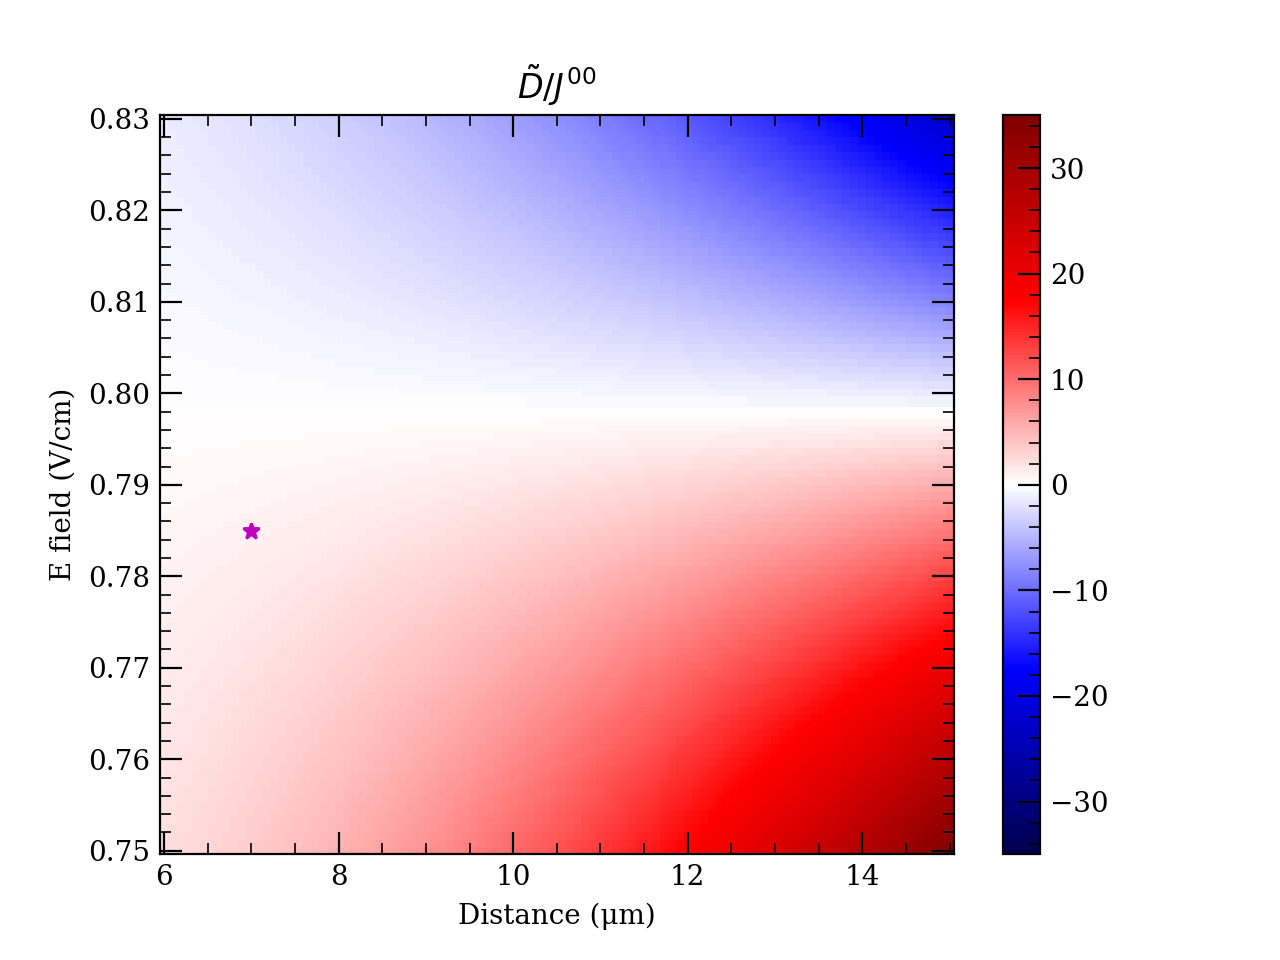

<IPython.core.display.Javascript object>


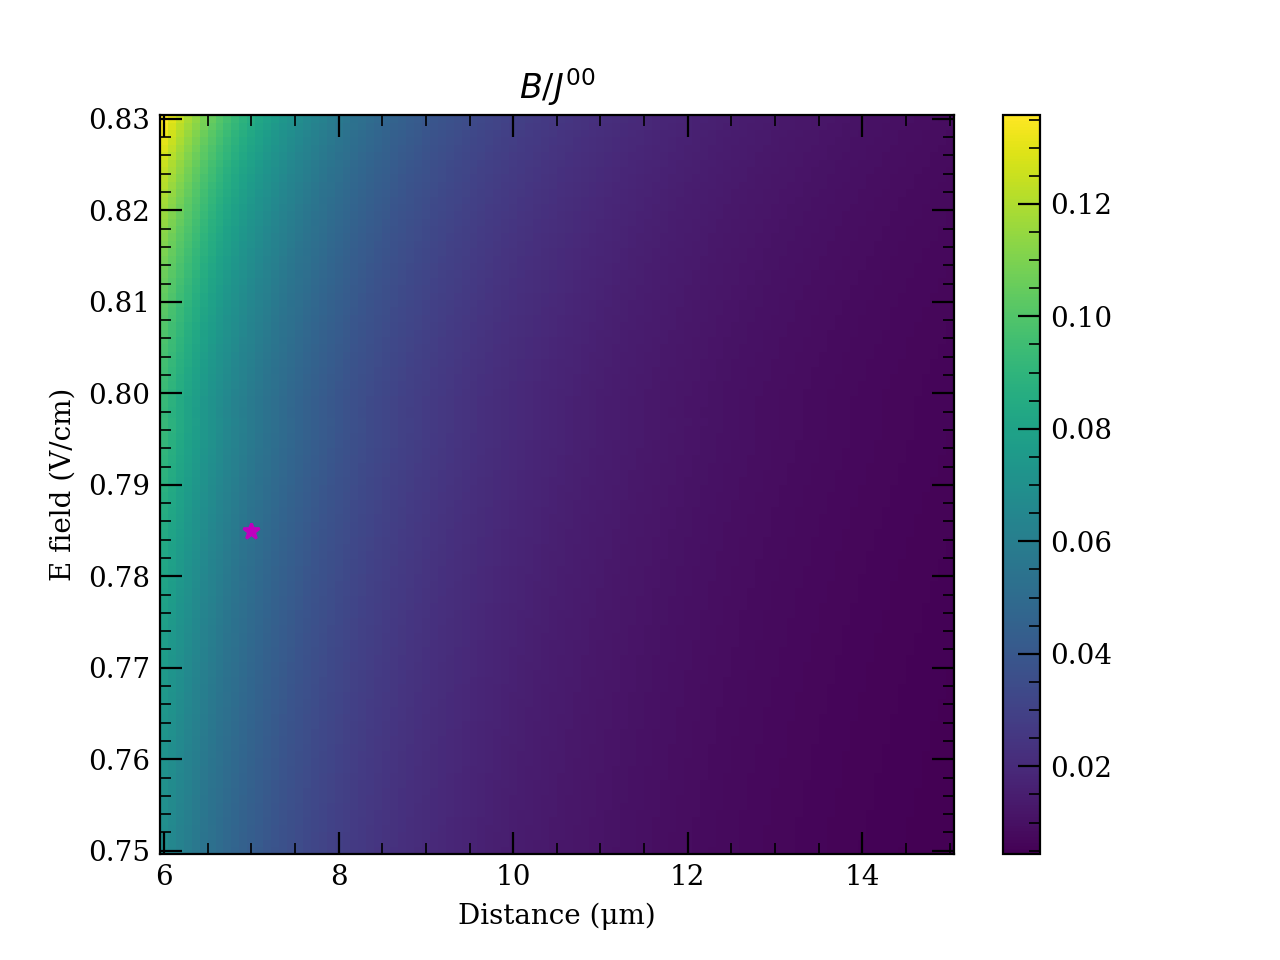

<IPython.core.display.Javascript object>


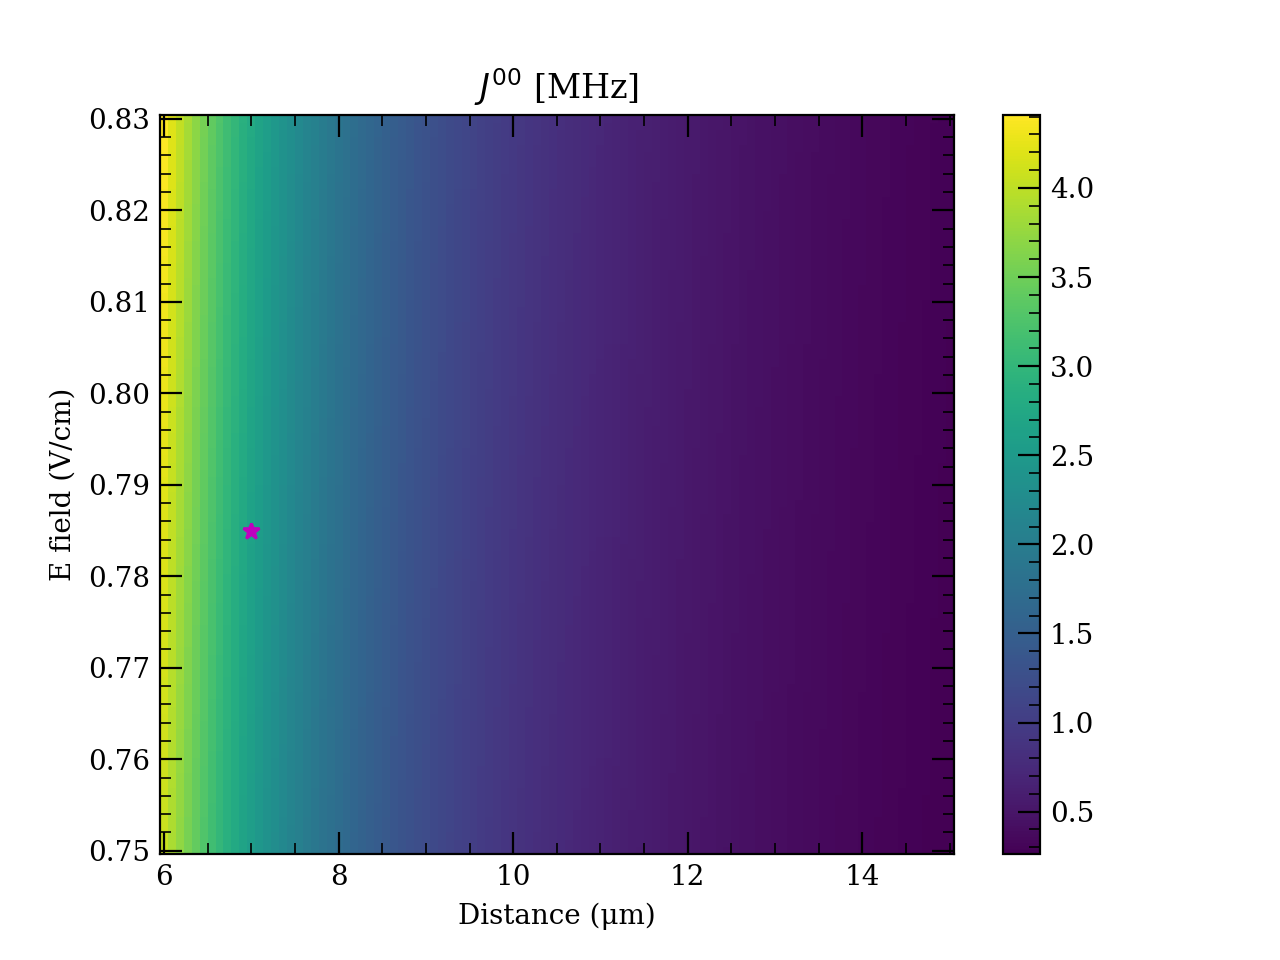

In [85]:
E_fields = np.linspace(0.75, 0.83, 100)

# plt.plot(E_fields, np.abs(np.transpose(popts)[2]))
ind = np.argsort(np.abs(np.transpose(popts)[0]))[0]
print(ind)

fixed_popts = [[np.transpose(popts)[i][j] for j in range(100) if j!=ind] for i in range(4)]
fixed_C3 = fixed_popts[0]
fixed_B = np.abs(fixed_popts[2])
fixed_V = fixed_popts[3]

E_fields_fixed = [E_fields[j] for j in range(100) if j!=ind]

min_D_ind = np.argsort(fixed_popts[1])[0]
print(min_D_ind)
fixed_D = fixed_popts[1]
for i in range(min_D_ind+1, len(fixed_D)):
    fixed_D[i] = -fixed_D[i]


C3 = []
for r in rs:
    temp = []
    for i,E in enumerate(E_fields_fixed):
        temp.append(1e3*fixed_C3[i]/r**3)
    C3.append(temp)

C3_D_tilde = []
for r in rs:
    temp = []
    for i,E in enumerate(E_fields_fixed):
#         temp.append((fixed_C3[i]/r**3) / (fixed_D[i] + np.abs((fixed_V[i]/r**6)/2)))
        temp.append((fixed_D[i] + np.abs((fixed_V[i]/r**6)/2)) / (fixed_C3[i]/r**3))
    C3_D_tilde.append(temp)

B_over_J = []
for r in rs:
    temp = []
    for i,E in enumerate(E_fields_fixed):
        temp.append((fixed_B[i]/r**6) / (fixed_C3[i]/r**3))
    B_over_J.append(temp)
# plt.plot(E_fields_fixed, fixed_C6)

E_val = 0.785
r_val = 7

im3_D = np.array(C3_D_tilde)

fig,ax = plt.subplots()
cmap = plt.colormaps['seismic']
c = ax.pcolormesh(rs, E_fields_fixed, np.transpose(im3_D), cmap = cmap, vmin = -35, vmax = 35)
ax.set_title(r'$\tilde{D}/J^{00}$')
fig.colorbar(c)
ax.set_xlabel('Distance (μm)')
ax.set_ylabel('E field (V/cm)')
ax.plot(r_val, E_val, "m*")
# ax.set_xlim(5,15)
# ax.set_ylim(0.15,0.19)

im6_3 = np.array(B_over_J)

fig,ax = plt.subplots()
c = ax.pcolormesh(rs, E_fields_fixed, np.transpose(im6_3))
ax.set_title(r'$B$/$J^{00}$')
fig.colorbar(c)
ax.set_xlabel('Distance (μm)')
ax.set_ylabel('E field (V/cm)')
ax.plot(r_val, E_val, "m*")
# ax.set_xlim(5,15)
# ax.set_ylim(0.15,0.19)

im3 = np.array(C3)

fig,ax = plt.subplots()
c = ax.pcolormesh(rs, E_fields_fixed, np.transpose(im3))
ax.set_title(r'$J^{00}$ [MHz]')
fig.colorbar(c)
ax.set_xlabel('Distance (μm)')
ax.set_ylabel('E field (V/cm)')
ax.plot(r_val, E_val, "m*")
# ax.set_xlim(5,15)
# ax.set_ylim(0.15,0.19)

<IPython.core.display.Javascript object>


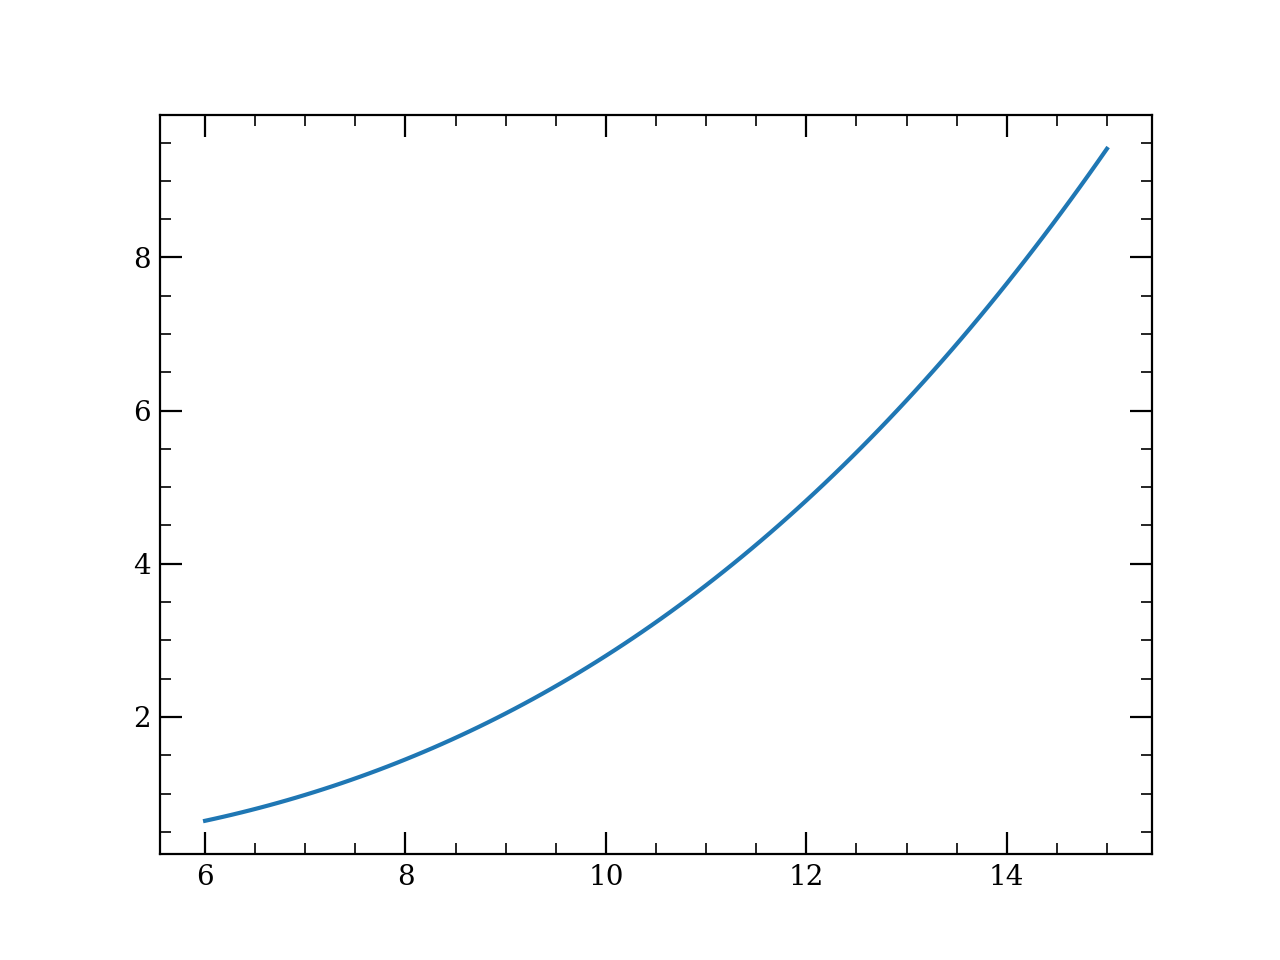

7.0
2.6457653592993045
0.053029191008082406
0.9828731242900106


In [83]:
E_val = 0.785
r_val = 7

field_ind = np.argsort(np.abs(E_fields_fixed - np.ones(np.size(E_fields_fixed))*E_val))[0]
r_ind = np.argsort(np.abs(rs - np.ones(np.size(rs))*r_val))[0]
plt.figure()
plt.plot(rs, np.transpose(im3_D)[field_ind])

one_ind = np.argsort(np.abs(np.transpose(im3_D)[field_ind] - np.ones(np.size(np.transpose(im3_D)[field_ind]))))[0]
print(rs[one_ind])

J_val = C3[r_ind][field_ind]
print(J_val)
B_val = B_over_J[r_ind][field_ind]
print(B_val)
D_over_J_val = C3_D_tilde[r_ind][field_ind]
print(D_over_J_val)

In [130]:
a = [1,1,2,3,4,5]
a.remove(2)
print(a)

[1, 1, 3, 4, 5]


Debugging:

<IPython.core.display.Javascript object>


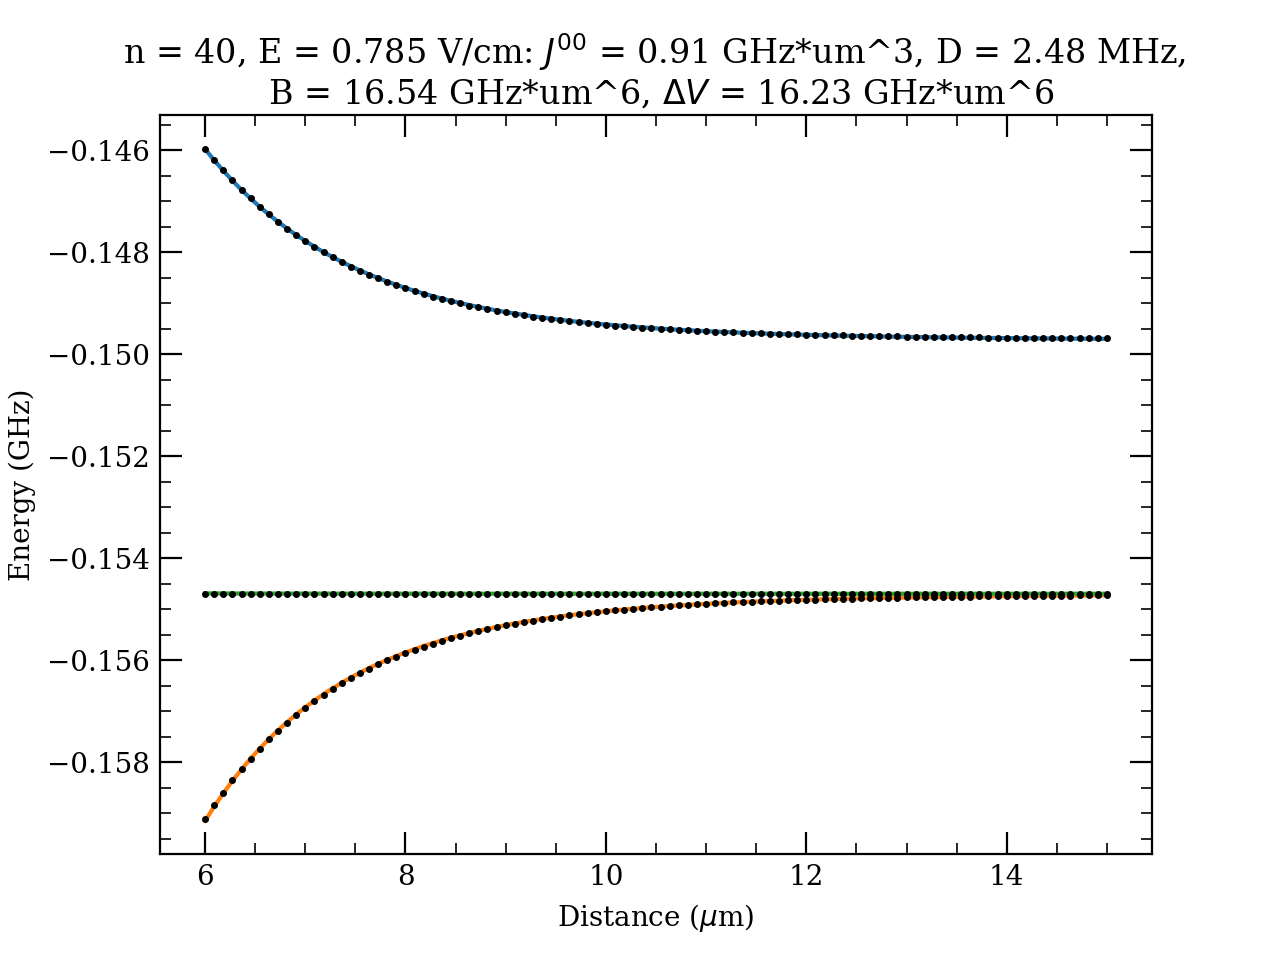

Text(0.5, 1.0, 'n = 40, E = 0.785 V/cm: $J^{00}$ = 0.91 GHz*um^3, D = 2.48 MHz, \n B = 16.54 GHz*um^6, $\\Delta V$ = 16.23 GHz*um^6')

In [92]:
n = 40

states = [[n,1,1.5,0.5],
          [n+1,0,0.5,0.5],
          [n,0,0.5,0.5],
          [n-1,2,2.5,1.5],
          [n-1,2,2.5,0.5],
          [n-1,2,2.5,-0.5],
          [n,1,1.5,-0.5],
          [n,1,1.5,1.5]]


pairstate0 = [states[0], state[0]]

pairstates = []
for state1 in states:
    for state2 in states:
        pairstate = [state1,state2]
        if pairstate not in pairstates:
            pairstates.append(pairstate)

state = [n,1,1.5,0.5]
pairstate0 = [state, state]

rs = np.linspace(6,15,100)
E_fields = [0.785]

Eigenenergies_3_level = three_level_energies(pairstates, pairstate0, 0, E_fields, rs)[0]

guess = (9.02065959e-01, 1.53353856e-03, 0, 0, -1.51609597e-01)
popt, pcov = curve_fit(expected_eigenenergies, rs, np.array(Eigenenergies_3_level))
# popt[2] = 0
# popt[3] = 0
# print(popt)
# print(pcov)
plt.figure()

# plt.plot(rs, expected_eigenenergies(rs, *guess)[:np.size(rs)])
plt.plot(rs, expected_eigenenergies(rs, *popt)[:np.size(rs)])
plt.plot(rs, Eigenenergies_3_level[:np.size(rs)], "k.", ms = 3)

# plt.plot(rs, expected_eigenenergies(rs, *guess)[np.size(rs):2*np.size(rs)])
plt.plot(rs, expected_eigenenergies(rs, *popt)[np.size(rs):2*np.size(rs)])
plt.plot(rs, Eigenenergies_3_level[np.size(rs):2*np.size(rs)], "k.", ms = 3)

# plt.plot(rs, expected_eigenenergies(rs, *guess)[2*np.size(rs):])
plt.plot(rs, expected_eigenenergies(rs, *popt)[2*np.size(rs):])
plt.plot(rs, Eigenenergies_3_level[2*np.size(rs):], "k.", ms = 3)

plt.xlabel(r"Distance ($\mu$m)")
plt.ylabel("Energy (GHz)")
j_str = r"$J^{00}$"
v_str = r"$\Delta V$"
plt.title(f"n = {n}, E = {E_fields[0]} V/cm: " + j_str + f" = {np.round(popt[0], 2)} GHz*um^3, D = {np.round(popt[1]*1e3,2)} MHz, \n B = {np.round(popt[2],2)} GHz*um^6, " + v_str + f" = {np.round(popt[3],2)} GHz*um^6", wrap=True)



<IPython.core.display.Javascript object>


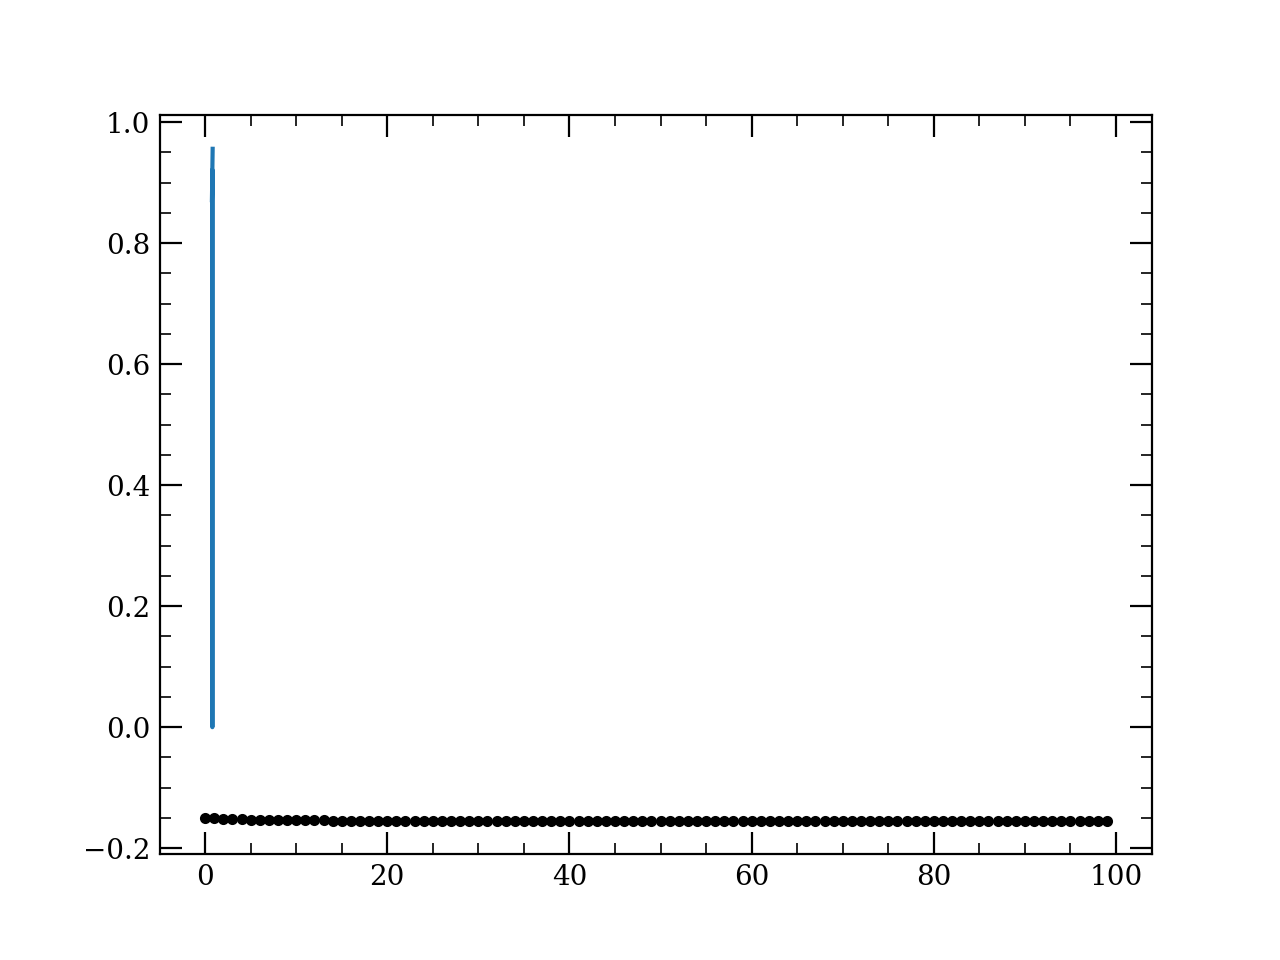

In [108]:
n = 40

states = [[n,1,1.5,0.5],
          [n+1,0,0.5,0.5],
          [n,0,0.5,0.5],
          [n-1,2,2.5,1.5],
          [n-1,2,2.5,0.5],
          [n-1,2,2.5,-0.5],
          [n,1,1.5,-0.5],
          [n,1,1.5,1.5]]


pairstate0 = [states[0], state[0]]

pairstates = []
for state1 in states:
    for state2 in states:
        pairstate = [state1,state2]
        if pairstate not in pairstates:
            pairstates.append(pairstate)

state = [n,1,1.5,0.5]
pairstate0 = [state, state]
# pairstates = make_basis_align(state, 4, 4, 10)
# print(np.shape(pairstates))

rs = np.linspace(6,50,100)
E_field = 0.8


H_test_pairstates = make_Hamiltonian_DUMB_pairstates(pairstates, pairstate0, 0, E_field, rs)
# print(H_test_pairstates[-1])

state_v_00 = state_vec(pairstates, [pairstates[0]])

plus_minus = [[n+1,0,0.5,0.5], [n,0,0.5,0.5]]
minus_plus = [[n,0,0.5,0.5], [n+1,0,0.5,0.5]]

state_v_pm = np.array(state_vec(pairstates, [plus_minus]))
state_v_mp = np.array(state_vec(pairstates, [minus_plus]))

state_v_singlet = (np.array(state_vec(pairstates, [plus_minus]))
                   - np.array(state_vec(pairstates, [minus_plus])))/np.sqrt(2)
state_v_triplet = (np.array(state_vec(pairstates, [plus_minus])) 
                   + np.array(state_vec(pairstates, [minus_plus])))/np.sqrt(2)

Eigenenergies_3_level = []
es, ws = max_overlap_eigenstates(H_test_pairstates, state_v_00, 1)
Eigenenergies_3_level = np.array(es)

es, ws = max_overlap_eigenstates(H_test_pairstates, state_v_triplet, 1)
Eigenenergies_3_level = np.append(Eigenenergies_3_level, np.array(es))

plt.figure()
for e in es:
    plt.plot(e, "k.")

es, ws = max_overlap_eigenstates(H_test_pairstates, state_v_singlet, 1)
Eigenenergies_3_level = np.append(Eigenenergies_3_level, np.array(es))

# print(Eigenenergies_3_level)
# plt.figure()
# for e in Eigenenergies_3_level:
#     plt.plot(e)

### Finding non 3-level contributions

In [30]:
#for each of the top N overlaps with state_vec in state_vecs, also calculate the contributions from the other
#statevecs

def overlap_other_states_singleH(H, state_vecs, N, min_percent):    
    eigvals, vecs = np.linalg.eig(H)
    eigvecs = np.transpose(vecs)
    
#     print(eigvecs, state_vec)
    overlaps = []
    highest_overlap_inds = []
    for state_vec in state_vecs:
        overlap = [np.abs(np.dot(state_vec, v)) for v in eigvecs]
        overlaps.append(overlap)
        highest_overlap_inds.append(np.argsort(overlap)[-N:])
    
#     print(highest_overlap_inds)
    
    non_contribution = []
    highest_overlap_eigvals = []
    for inds in highest_overlap_inds:
        for ind in inds:
            good_admixture = 0
            for overlap in overlaps:
                good_admixture += overlap[ind]**2
            if good_admixture > min_percent/100:
                highest_overlap_eigvals.append(eigvals[ind])
                non_contribution.append(good_admixture)
            else:
                highest_overlap_eigvals.append(np.nan)
                non_contribution.append(np.nan)
    
    return highest_overlap_eigvals, non_contribution

def overlap_other_states(Hs, state_vec, N, min_percent):
    eigs = []
    weights = []
    for H in Hs:
#         print("hi")
        e, w = overlap_other_states_singleH(H, state_vec, N, min_percent)
        eigs.append(e)
        weights.append(w)
    return np.transpose(eigs), np.transpose(weights)

In [190]:
def effective_H_purity(state_v_00, plus_minus, minus_plus, rs, Es):
    state_v_singlet = (np.array(state_vec(pairstates, [plus_minus]))
                       - np.array(state_vec(pairstates, [minus_plus])))/np.sqrt(2)
    state_v_triplet = (np.array(state_vec(pairstates, [plus_minus])) 
                       + np.array(state_vec(pairstates, [minus_plus])))/np.sqrt(2)

    state_vecs = [state_v_00, state_v_singlet, state_v_triplet]
    
    min_ws = []
    for E in Es:
        H_test_pairstates = make_Hamiltonian_DUMB_pairstates(pairstates, pairstate0, 0, E, rs)
#         es, ws = overlap_other_states(H_test_pairstates, state_vecs, 2, 3)
        es, ws = overlap_other_states(H_test_pairstates, state_vecs, 3, 3)
        min_w = []        
        for weights in np.transpose(ws):
#             min_w.append(np.nanmin(weights))
            min_w.append(weights[np.argsort(weights)[3]])
        min_ws.append(min_w)
    
    return(min_ws)

In [191]:
array = [np.nan,1,2,3]

array[np.argsort(array)[1]]

2

<IPython.core.display.Javascript object>


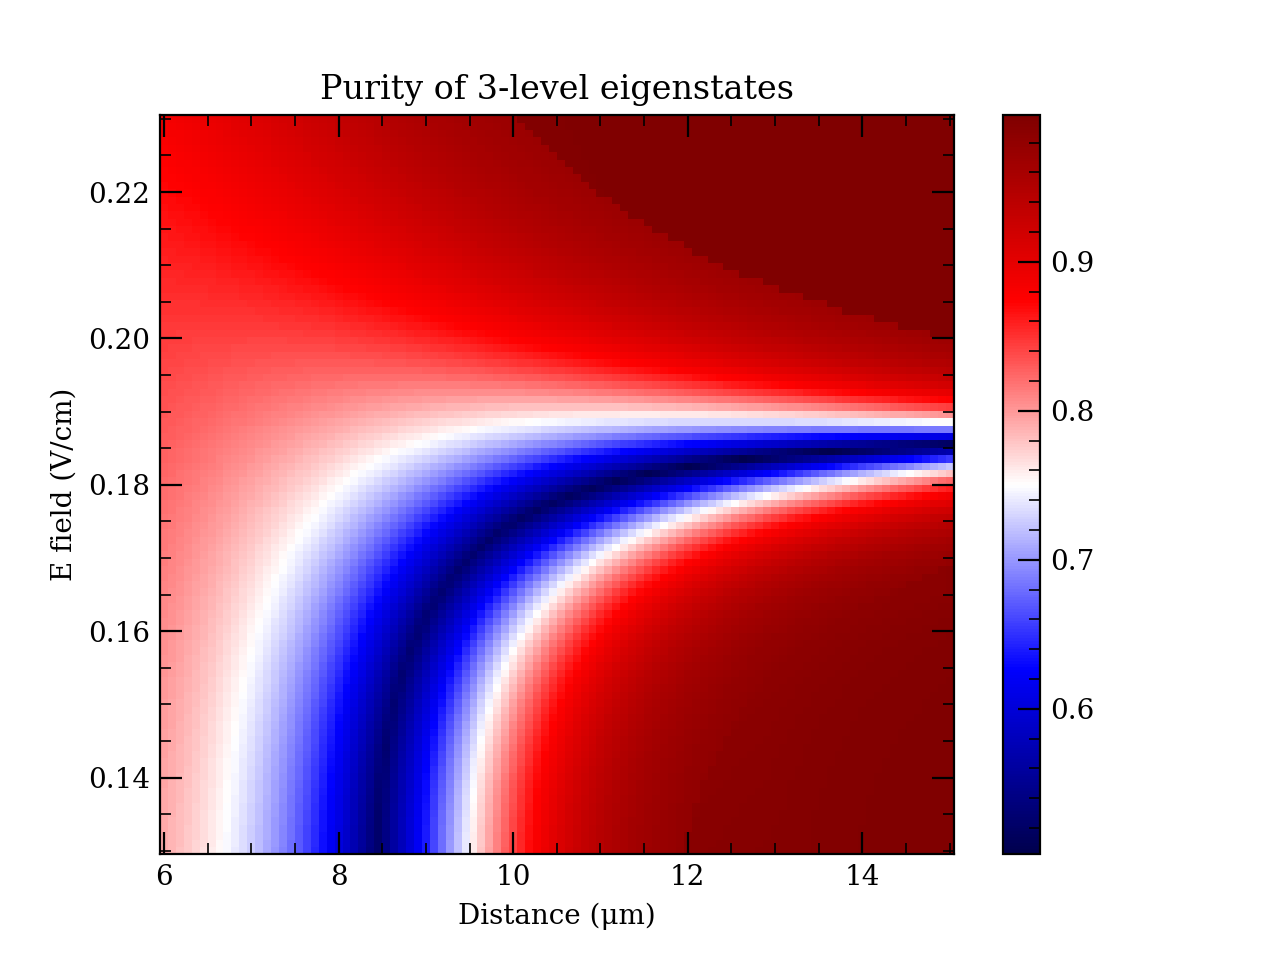

Text(0, 0.5, 'E field (V/cm)')

In [192]:
n = 42

states = [[n,1,1.5,0.5],
          [n+1,0,0.5,0.5],
          [n,0,0.5,0.5],
          [n-1,2,2.5,1.5],
          [n-1,2,2.5,0.5],
          [n-1,2,2.5,-0.5],
          [n,1,1.5,-0.5],
          [n,1,1.5,1.5]]


pairstate0 = [states[0], state[0]]

pairstates = []
for state1 in states:
    for state2 in states:
        pairstate = [state1,state2]
        if pairstate not in pairstates:
            pairstates.append(pairstate)

state = [n,1,1.5,0.5]
pairstate0 = [state, state]
# pairstates = make_basis_align(state, 4, 4, 10)
# print(np.shape(pairstates))

state_v_00 = state_vec(pairstates, [pairstates[0]])
plus_minus = [[n+1,0,0.5,0.5], [n,0,0.5,0.5]]
minus_plus = [[n,0,0.5,0.5], [n+1,0,0.5,0.5]]

rs = np.linspace(6,15,100)
E_fields = np.linspace(0.13, 0.23, 100)
ws = effective_H_purity(state_v_00, plus_minus, minus_plus, rs, E_fields)


fig,ax = plt.subplots()
c = ax.pcolormesh(rs, E_fields, ws, cmap = mpl.cm.seismic)
ax.set_title(r'Purity of 3-level eigenstates')
fig.colorbar(c)
ax.set_xlabel('Distance (μm)')
ax.set_ylabel('E field (V/cm)')

In [180]:
print(E_fields)

[0.13       0.13526316 0.14052632 0.14578947 0.15105263 0.15631579
 0.16157895 0.16684211 0.17210526 0.17736842 0.18263158 0.18789474
 0.19315789 0.19842105 0.20368421 0.20894737 0.21421053 0.21947368
 0.22473684 0.23      ]


(64, 2, 4)


<IPython.core.display.Javascript object>


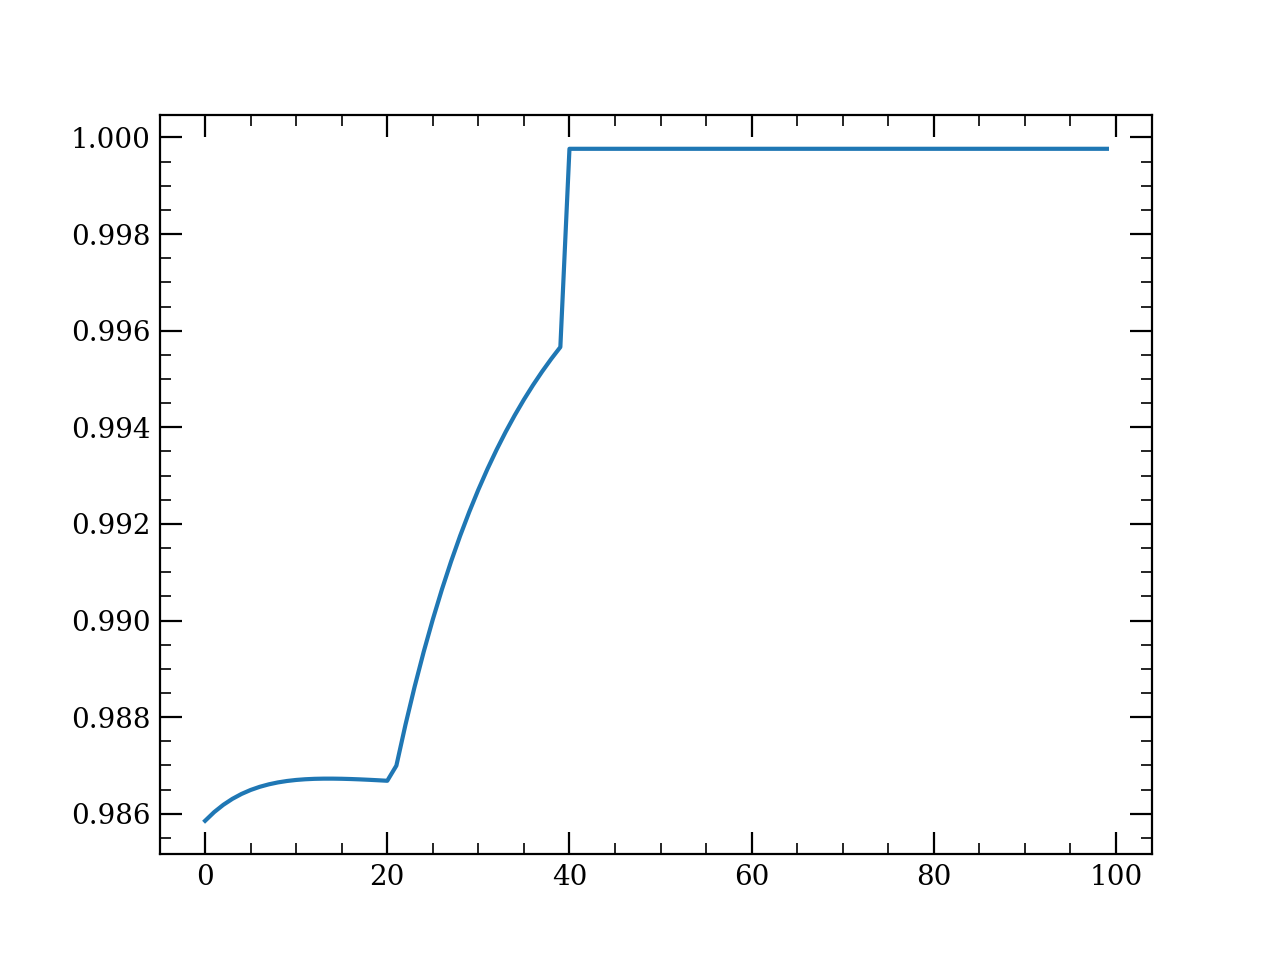

<IPython.core.display.Javascript object>


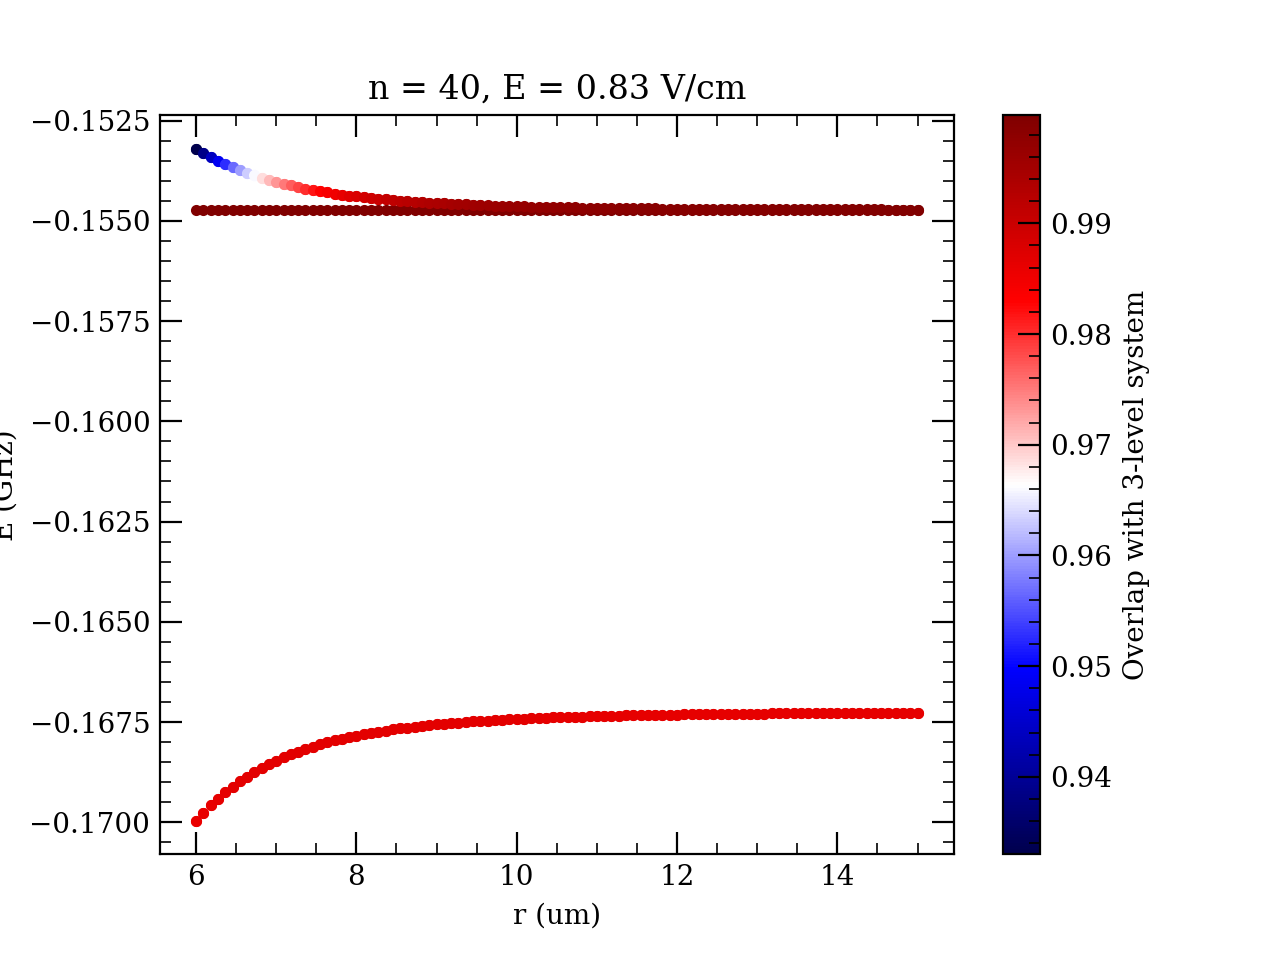

Text(0, 0.5, 'E (GHz)')

In [194]:
n = 40

states = [[n,1,1.5,0.5],
          [n+1,0,0.5,0.5],
          [n,0,0.5,0.5],
          [n-1,2,2.5,1.5],
          [n-1,2,2.5,0.5],
          [n-1,2,2.5,-0.5],
          [n,1,1.5,-0.5],
          [n,1,1.5,1.5]]


pairstate0 = [states[0], state[0]]

pairstates = []
for state1 in states:
    for state2 in states:
        pairstate = [state1,state2]
        if pairstate not in pairstates:
            pairstates.append(pairstate)

state = [n,1,1.5,0.5]
pairstate0 = [state, state]
# pairstates = make_basis_align(state, 4, 4, 10)
print(np.shape(pairstates))


state_v_00 = state_vec(pairstates, [pairstates[0]])

plus_minus = [[n+1,0,0.5,0.5], [n,0,0.5,0.5]]
minus_plus = [[n,0,0.5,0.5], [n+1,0,0.5,0.5]]

rs = np.linspace(6,15,100)

E_field = 0.83
H_test_pairstates = make_Hamiltonian_DUMB_pairstates(pairstates, pairstate0, 0, E_field, rs)
# print(H_test_pairstates[-1])

state_v_pm = np.array(state_vec(pairstates, [plus_minus]))
state_v_mp = np.array(state_vec(pairstates, [minus_plus]))

state_v_singlet = (np.array(state_vec(pairstates, [plus_minus]))
                   - np.array(state_vec(pairstates, [minus_plus])))/np.sqrt(2)
state_v_triplet = (np.array(state_vec(pairstates, [plus_minus])) 
                   + np.array(state_vec(pairstates, [minus_plus])))/np.sqrt(2)

state_vecs = [state_v_00, state_v_singlet, state_v_triplet]
es, ws = overlap_other_states(H_test_pairstates, state_vecs, 2, 3)
min_w = []        
for weights in np.transpose(ws):
#     min_w.append(np.nanmin(weights))
    min_w.append(weights[np.argsort(weights)[3]])
plt.figure()
plt.plot(min_w)
# print([i for i in enumerate(np.transpose(ws))])

plt.figure()

vmin = min([min(w) for w in ws])
vmax = max([max(w) for w in ws])

cmap = mpl.cm.seismic
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

for e, w in zip(es, ws):
    for i,en in enumerate(e):
        color = cmap(norm(w[i]))
        plt.plot(rs[i], en, c = color, marker =".")

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) 
sm.set_array([]) 

plt.colorbar(sm, label="Overlap with 3-level system")
plt.title(f"n = {n}, E = {E_field} V/cm")
plt.xlabel("r (um)")
plt.ylabel("E (GHz)")

# plt.figure()
# for i,en in enumerate(es[0]):
#     color = cmap(norm(ws[0][i]))
#     plt.plot(rs[i], en, c = color, marker =".")

### Clicking on States on the plot

In [36]:
def plot_eigenvalues(eigenvalues, eigenvectors, rs, pairstates, N, y_lims = None):
    fig, ax = plt.subplots()
    scatter_plot = None
    
    for ev in np.transpose(eigenvalues):
        ax.scatter(rs, ev, c = "k", s = 3)

    ax.set_ylabel('E (GHz)')
    ax.set_xlabel('r (μs)')
    ax.set_title('Eigenvalues of H')
    if y_lims != None:
        ax.set_ylim(y_lims)

    def onclick(event):
        nonlocal scatter_plot
        
        if event.inaxes is not None:
            x, y = event.xdata, event.ydata
            if x is not None and y is not None:
                clicked_eigval = (x,y)
                closest_eigval, matrix_index, eigenvector_index = find_closest_eigenvalue(clicked_eigval, eigenvalues, rs)
                if closest_eigval is not None:
                    if scatter_plot is not None:
                        scatter_plot.remove()  # Remove previously placed red square
                    eigenvector = eigenvectors[matrix_index][:, eigenvector_index]
                    
                    title = "Eigenvector: " + eigenstate_name(pairstates, eigenvector, N)
                    
                    ax.set_title(title, wrap=True)
                    scatter_plot = ax.scatter(rs[matrix_index], closest_eigval, marker='s', color='red', s = 4)
                    plt.draw()

    fig.canvas.mpl_connect('button_press_event', onclick)

    plt.show()

def find_closest_eigenvalue(clicked_eigval, eigenvalues, rs):
    closest_eigval = None
    min_distance = float('inf')
    matrix_index = eigenvector_index = None
    for i, ev in enumerate(eigenvalues):
        for j, val in enumerate(ev):
            distance = np.sqrt((clicked_eigval[0] - rs[i])**2 + (clicked_eigval[1] - val)**2)
            if distance < min_distance:
                min_distance = distance
                closest_eigval = val
                matrix_index = i
                eigenvector_index = j
    return closest_eigval, matrix_index, eigenvector_index

In [45]:
from fractions import Fraction

def state_name(state):
    ls = ['S', 'P', 'D', 'F']
    
    n = state[0]
    l = ls[int(state[1])]
    j = Fraction(state[2]).limit_denominator()
    mj = Fraction(state[3]).limit_denominator()
    
    return (f"{n}{l}_{j}, {mj}")

def eigenstate_name(pairstates, state_vec, N):
    highest_overlap_inds = np.argsort(np.abs(np.array(state_vec)))[-N:]
    
    state_names = []
    for ind in highest_overlap_inds:
        pairstate_name = state_name(pairstates[ind][0])+" "+state_name(pairstates[ind][1])
        state_names.append(str(round(state_vec[ind],3)) + "("+ pairstate_name + ")")
    
    name = state_names[-1]
    state_names.reverse()
    for n in state_names[1:]:
        name = name+" + "+n
    
    return name

(64, 2, 4)
[[  0.          -0.77069347  -0.78794475 ...   0.           0.
    0.        ]
 [ -0.77069347  67.87942453   0.         ...   0.           0.
    0.        ]
 [ -0.78794475   0.         -68.03381826 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...  12.58745754  -1.09365659
    0.        ]
 [  0.           0.           0.         ...  -1.09365659   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]


<IPython.core.display.Javascript object>


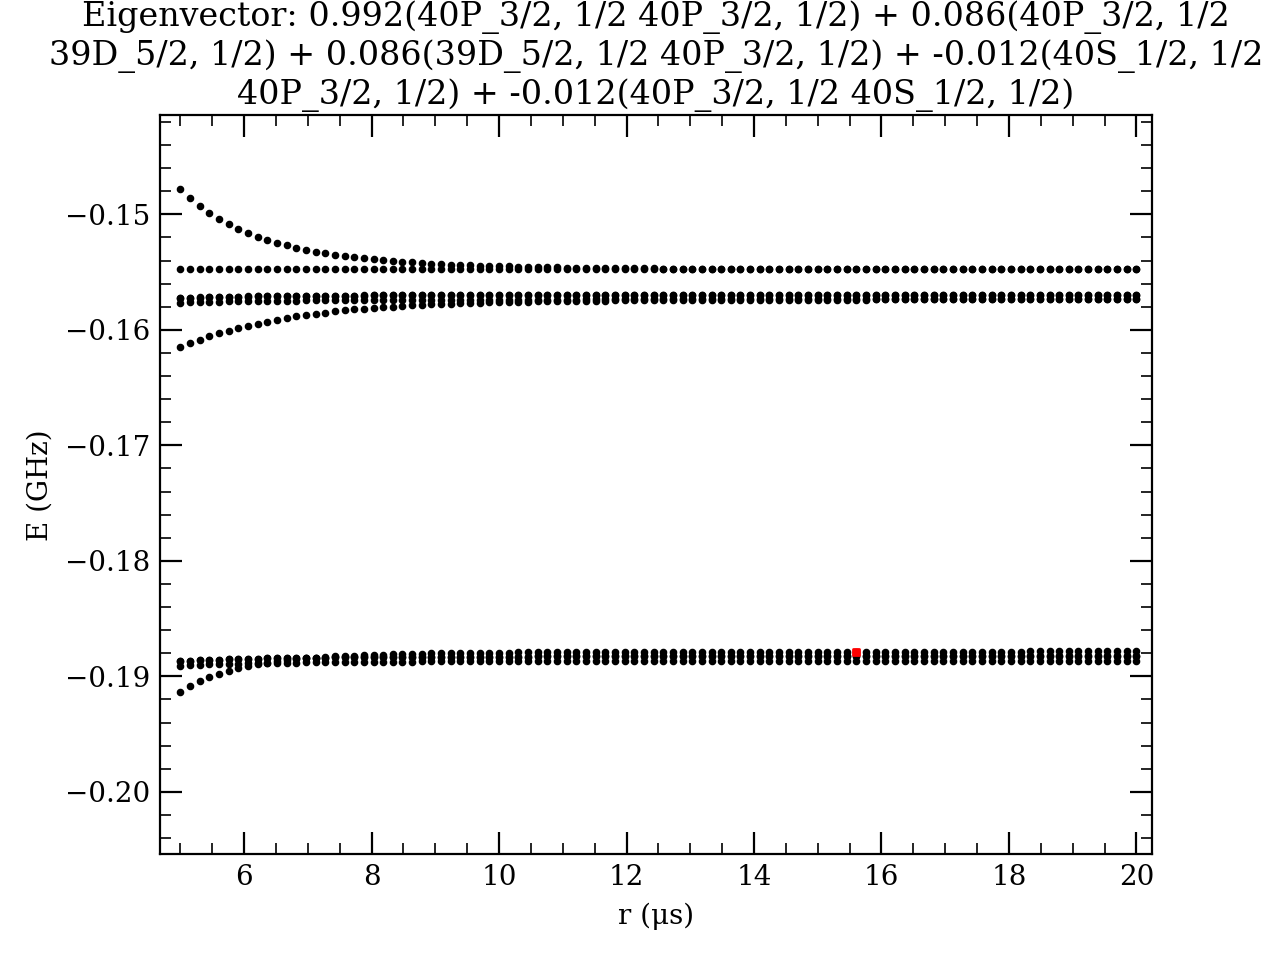

(-0.5, 0.5)

In [47]:
n = 40

states = [[n,1,1.5,0.5],
          [n+1,0,0.5,0.5],
          [n,0,0.5,0.5],
          [n-1,2,2.5,1.5],
          [n-1,2,2.5,0.5],
          [n-1,2,2.5,-0.5],
          [n,1,1.5,-0.5],
          [n,1,1.5,1.5]]

# states = [[44,40,40.5,40.5],
#           [43,20,20.5,20.5]]

pairstate0 = [states[0], state[0]]

pairstates = []
for state1 in states:
    for state2 in states:
        pairstate = [state1,state2]
        if pairstate not in pairstates:
            pairstates.append(pairstate)

state = [n,1,1.5,0.5]
pairstate0 = [state, state]
# pairstates = make_basis_align(state, 4, 4, 10)
print(np.shape(pairstates))

rs = np.linspace(5,20,100)

H_test_pairstates = make_Hamiltonian_DUMB_pairstates(pairstates, pairstate0, 0, 0.88, rs)
print(H_test_pairstates[-1])

energies = []
eigvecs = []

for H in H_test_pairstates:
    eigvals, vecs = eig(H)
    energies.append(eigvals)
    eigvecs.append(vecs)

plot_eigenvalues(energies, eigvecs, rs, pairstates, 5)
plt.ylim(-0.5, 0.5)

[40, 1, 1.5, 0.5]
(144, 2, 4)
[[[38, 0, 0.5, -0.5], [42, 2, 2.5, -2.5]], [[38, 0, 0.5, -0.5], [42, 2, 2.5, -1.5]], [[38, 0, 0.5, -0.5], [42, 2, 2.5, -0.5]], [[38, 0, 0.5, -0.5], [42, 2, 2.5, 0.5]], [[38, 0, 0.5, -0.5], [42, 2, 2.5, 1.5]], [[38, 0, 0.5, -0.5], [42, 2, 2.5, 2.5]], [[38, 0, 0.5, 0.5], [42, 2, 2.5, -2.5]], [[38, 0, 0.5, 0.5], [42, 2, 2.5, -1.5]], [[38, 0, 0.5, 0.5], [42, 2, 2.5, -0.5]], [[38, 0, 0.5, 0.5], [42, 2, 2.5, 0.5]], [[38, 0, 0.5, 0.5], [42, 2, 2.5, 1.5]], [[38, 0, 0.5, 0.5], [42, 2, 2.5, 2.5]], [[38, 2, 2.5, -2.5], [41, 1, 1.5, -1.5]], [[38, 2, 2.5, -2.5], [41, 1, 1.5, -0.5]], [[38, 2, 2.5, -2.5], [41, 1, 1.5, 0.5]], [[38, 2, 2.5, -2.5], [41, 1, 1.5, 1.5]], [[38, 2, 2.5, -1.5], [41, 1, 1.5, -1.5]], [[38, 2, 2.5, -1.5], [41, 1, 1.5, -0.5]], [[38, 2, 2.5, -1.5], [41, 1, 1.5, 0.5]], [[38, 2, 2.5, -1.5], [41, 1, 1.5, 1.5]], [[38, 2, 2.5, -0.5], [41, 1, 1.5, -1.5]], [[38, 2, 2.5, -0.5], [41, 1, 1.5, -0.5]], [[38, 2, 2.5, -0.5], [41, 1, 1.5, 0.5]], [[38, 2, 2.5, -0.5],

<IPython.core.display.Javascript object>


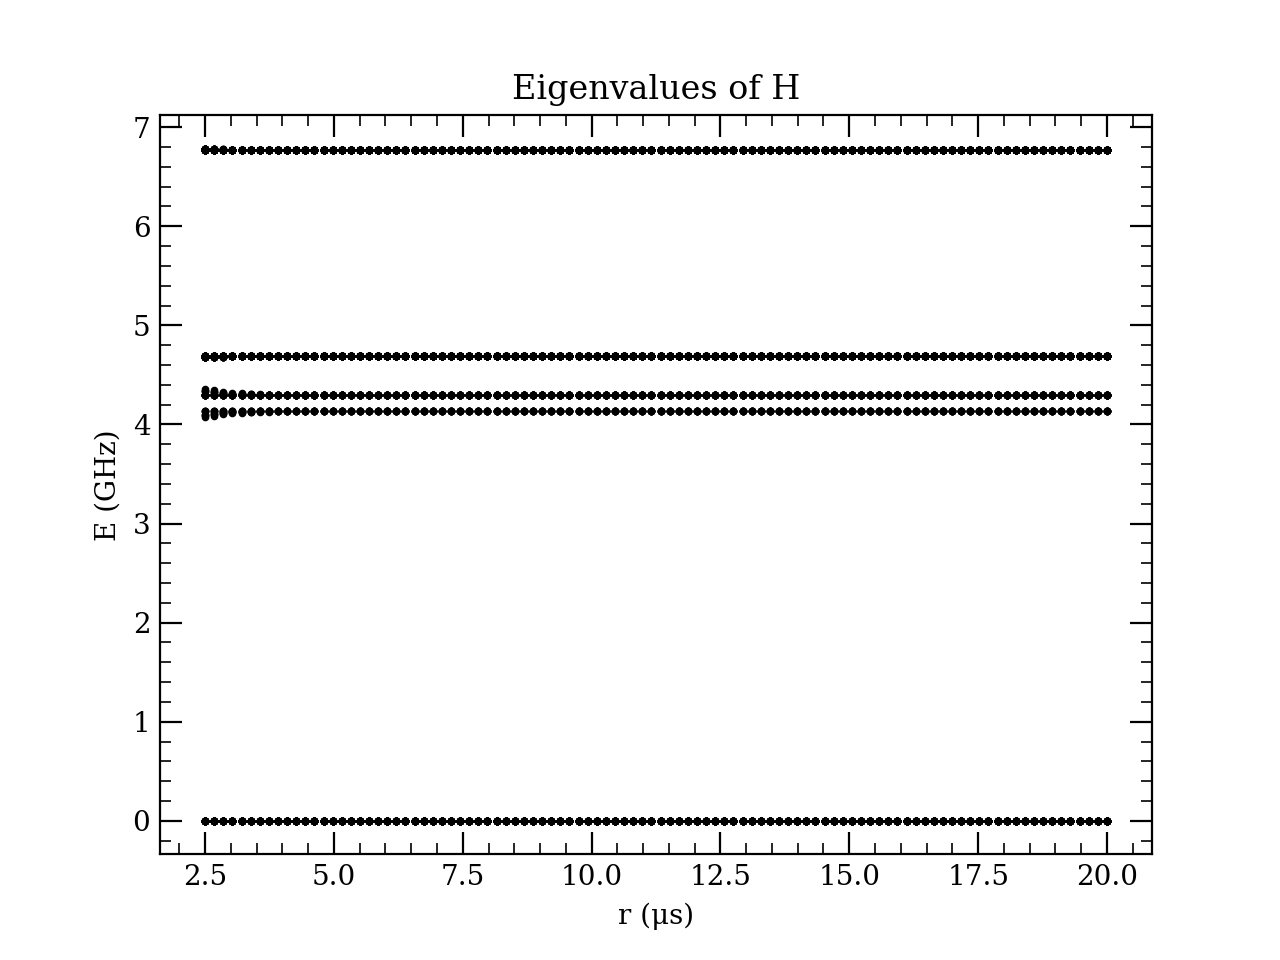

In [42]:
n = 40
dn = 2
l_max = 3
dE_max = 10

state_0 = [n, int(l_max/2), int(l_max/2)+0.5, 0.5]
print(state_0)
pairstate_0 = [state_0, state_0]
E_0 = pairstate_E(pairstate_0)

states = []
for nn in np.arange(n-dn, n+dn+1, 1):
    for l in range(0, l_max+1):
        j = l+1/2
        for m in np.arange(-j, j+1, 1):
            states.append([nn,l,j,m])
# print(states)
pairstates = []
for s in states:
    for ss in states:
        if np.abs(E_0 - pairstate_E([s,ss]))<dE_max:
            pairstates.append([s,ss])
print(np.shape(pairstates))
print(pairstates)

rs = np.linspace(2.5,20,100)

H_test_pairstates_0 = make_Hamiltonian_DUMB_pairstates(pairstates, pairstates[0], 0, 0.8, rs)
# print(H_test_pairstates_0[-1])
test_es, test_vs = eig(H_test_pairstates_0[-1])
# print(np.transpose(test_vs))

energies = []
eigvecs = []

for H in H_test_pairstates_0:
    eigvals, vecs = eig(H)
    energies.append(eigvals)
    eigvecs.append(vecs)

plot_eigenvalues(energies, eigvecs, rs, pairstates, 5)

<IPython.core.display.Javascript object>


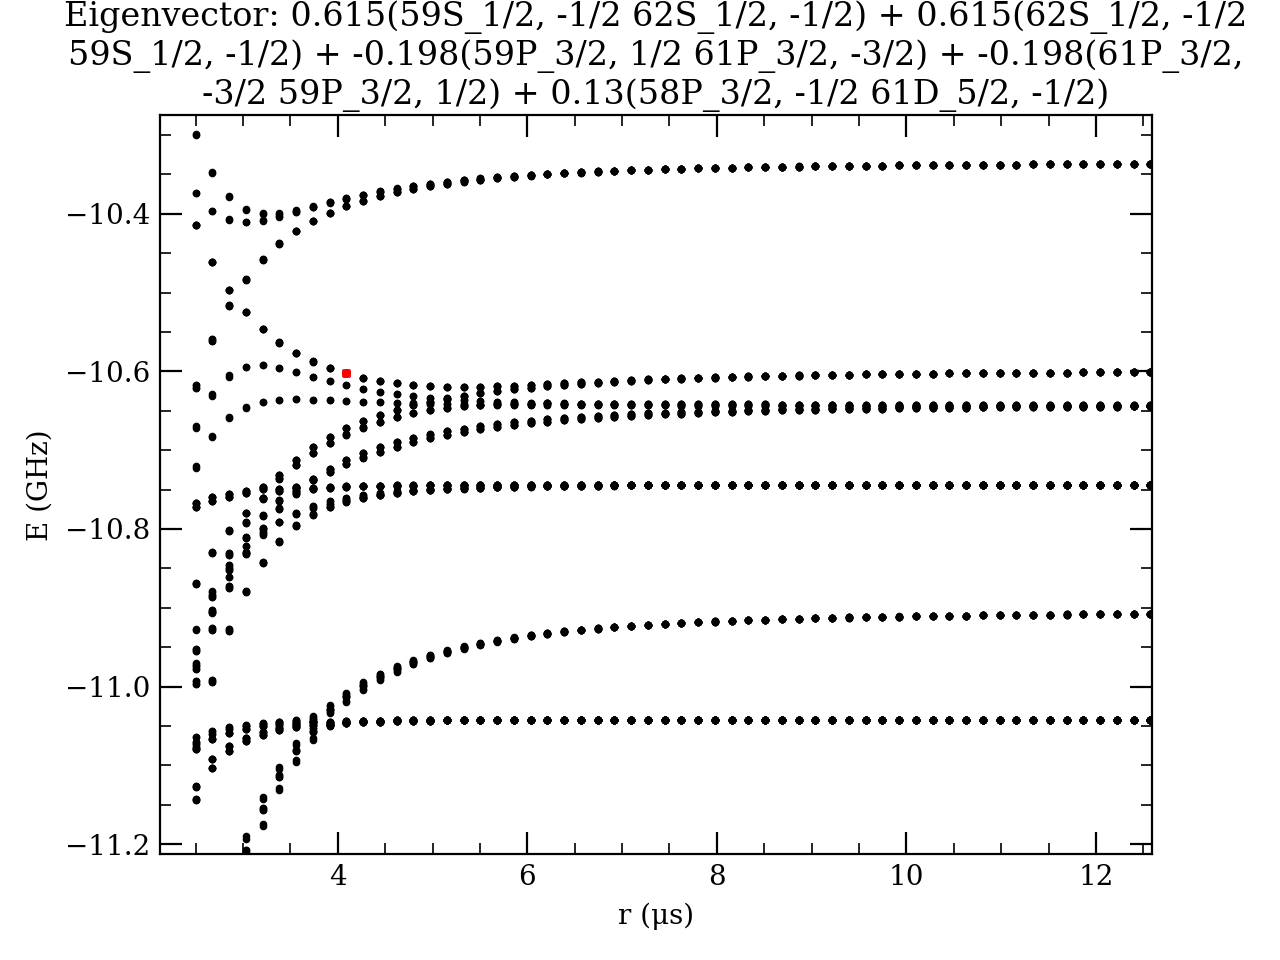

In [79]:
plot_eigenvalues(energies, eigvecs, rs, pairstates, 5)

In [672]:
state11 = [42,1,1.5,0.5]
state12 = [43,0,0.5,0.5]
state21 = [43,0,0.5,0.5]
state22 = [42,1,1.5,0.5]

# state11 = [42,1,1.5,1.5]
# state12 = [42,1,1.5,1.5]
# state21 = [43,0,0.5,0.5]
# state22 = [42,0,0.5,0.5]

pairstate1 = [state11, state12]
pairstate2 = [state21, state22]

pairstates = [pairstate1, pairstate2]
print(np.shape(pairstates))

# print(C_e**2 / (4.0 * pi * epsilon_0))

V_dd_coupling_aligned(pairstate1, pairstate2)/10**3

(2, 2, 4)


-0.011164214313867216

In [103]:
Caesium().getRadialCoupling(42, 0, 0.5, 42, 0, 0.5, s=1/2)

5186784.752833036

In [37]:
j = 0.5
j1 = 1.5
l = 0
l1 = 1
print(Wigner6j(l, 1/2, j, j1, 1, l1))

print(Wigner3j(0, 1, 1, 0, 0, 0))

-0.408248290463863
-0.5773502691896257


In [675]:
state11 = [42,1,1.5,1.5]
state12 = [43,0,0.5,0.5]
state21 = [43,0,0.5,0.5]
state22 = [42,1,1.5,1.5]

pairstate1 = state11 + state12
pairstate2 = state21 + state22

n,l,j,mj,nn,ll,jj,mmj = pairstate1
n1,l1,j1,mj1,n2,l2,j2,mj2 = pairstate2
    
coupling_strength = _atomLightAtomCoupling(
    n,l,j,nn,ll,jj,n1,l1,j1,n2,l2,j2,
    Caesium(),
    atom2=Caesium(),
    s=1/2,
    s2=1/2,
)/ C_h* 1.0e-9*(1e6**3)

def DD_coupling_radial_integral(pairstate1, pairstate2):
    n,l,j,mj,nn,ll,jj,mmj = pairstate1
    n1,l1,j1,mj1,n2,l2,j2,mj2 = pairstate2
    
#     print(pairstate1, pairstate2)

    coupling_strength = _atomLightAtomCoupling(
        n,l,j,nn,ll,jj,n1,l1,j1,n2,l2,j2,
        Caesium(),
        atom2=Caesium(),
        s=1/2,
        s2=1/2,
    )/ C_h * 1.0e-9 * (1e6**3)
#     print(coupling_strength)
    return coupling_strength

print(coupling_strength, DD_coupling_radial_integral(pairstate1, pairstate2))

2.545135669614952 2.545135669614952


In [ ]:

def ARC_dd_coupling(pairstate1, pairstate2, r):
    n1,l1,j1,m1,n2,l2,j2,m2 = pairstate1
    nn1,ll1,jj1,mm1,nn2,ll2,jj2,mm2 = pairstate1
    calc = PairStateInteractions(Caesium(),n1 ,l1 ,j1 ,n2 ,l2 ,j2 ,m1 ,m2, interactionsUpTo = 1)
    calc.defineBasis(0 ,0 , 5, 5, 25e9, progressOutput=True)

# def ARC_dd_coupling(pairstate1, pairstate2, r):
#     couplingStregth = (
#         _atomLightAtomCoupling(
#             self.n,
#             self.l,
#             self.j,
#             self.nn,
#             self.ll,
#             self.jj,
#             n1,
#             l1,
#             j1,
#             n2,
#             l2,
#             j2,
#             self.atom1,
#             atom2=self.atom2,
#             s=self.s1,
#             s2=self.s2,
#         )
#         * (1.0e-9 * (1.0e6) ** 3 / C_h)
#     )  # GHz / mum^3
#     d = self.__getAngularMatrix_M(
#         self.l,
#         self.j,
#         self.ll,
#         self.jj,
#         l1,
#         j1,
#         l2,
#         j2,
#     )